<a href="https://colab.research.google.com/github/JozefV99/Master-Thesis/blob/main/experiments/EXPERIMENT_2_Faster_RCNN_LOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EXPERIMENT 2 - Faster RCNN - LOW**

This code trains the fasterrcnn_mobilenet_v3_large_fpn model on the low complexity dataset, providing training, validation, and testing results, including visualizations. Testing results are based on both synthetic and traditional datasets.

# **IMPORT TRAINING DATASET:**

In [ ]:
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/gdrive')

# Path to folder on Google Drive
path_to_folder = "/content/gdrive/My Drive/Colab Notebooks/Data/LOW COMPLEXITY/XML DATASET"

# Create a main folder called 'Datasets'
images_folder_path = '/content/Datasets'
os.makedirs(images_folder_path, exist_ok=True)

# Unzipping each zip file into a separate subfolder within 'Datasets'
for zip_file in os.listdir(path_to_folder):
    if zip_file.endswith('.zip'):
        # Create a directory named after the zip file (without the .zip extension)
        # within the 'Datasets' folder
        folder_name = zip_file[:-4]
        subfolder_path = os.path.join(images_folder_path, folder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # Path to the zip file in Google Drive
        zip_path = os.path.join(path_to_folder, zip_file)

        # Unzip the files into the newly created subfolder
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(subfolder_path)

print("Unzipping complete.")

# Print the final directory structure for verification
print("Contents of the 'Datasets' directory:")
!ls {images_folder_path}

Mounted at /content/gdrive
Unzipping complete.
Contents of the 'Datasets' directory:
training_XML  validation_XML


In [ ]:
import os

def count_files_in_directory(directory_path):
    # Initialize counters
    total_files = 0
    image_files = 0
    other_files = 0
    other_file_types = {}

    # Supported image file extensions
    image_extensions = {'.png', '.jpg', '.jpeg'}

    # Iterate through files in the directory
    for file in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, file)):
            total_files += 1
            file_extension = os.path.splitext(file)[1].lower()  # Extract file extension

            # Check file extension
            if file_extension in image_extensions:
                image_files += 1
            else:
                other_files += 1
                if file_extension in other_file_types:
                    other_file_types[file_extension] += 1
                else:
                    other_file_types[file_extension] = 1

    return total_files, image_files, other_files, other_file_types

# Specify the directory to check
directory_path = '/content/Datasets/training_XML'

# Count the files
total_files, image_files, other_files, other_file_types = count_files_in_directory(directory_path)

# Print the counts
print(f"Total files: {total_files}")
print(f"Number of image files: {image_files}")
print(f"Number of other files: {other_files}")
print("Other file types:")
for ext, count in other_file_types.items():
    print(f"{ext}: {count}")

Total files: 80000
Number of image files: 40000
Number of other files: 40000
Other file types:
.xml: 40000


# **IMPORT TESTING DATASET:**

### **SYNTHETIC TESTING DATASET:**

In [ ]:
import os
import shutil
import zipfile
import numpy as np
from PIL import Image
from google.colab import drive

# Mount Google Drive
#drive.mount('/content/gdrive')

def normalize_and_save(img_path, save_path):
    # Open the image file
    img = Image.open(img_path)
    img = img.convert('RGB')  # Convert to RGB if not already

    # Normalize pixel values to [0, 1] and scale back to [0, 255]
    np_img = np.array(img) / 255.0
    norm_img = Image.fromarray((np_img * 255).astype('uint8'))
    norm_img.save(save_path)
    os.remove(img_path)  # Optionally remove the original image

def extract_and_normalize_images(source_folder, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for zip_filename in os.listdir(source_folder):
        if zip_filename.endswith('.zip'):
            zip_path = os.path.join(source_folder, zip_filename)
            with zipfile.ZipFile(zip_path, 'r') as zip_file:
                zip_file.extractall(target_folder)
                print(f"Extracted {zip_filename} into {target_folder}")

                # Normalize each image extracted
                for filename in os.listdir(target_folder):
                    file_path = os.path.join(target_folder, filename)
                    if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                        normalize_and_save(file_path, file_path)  # Save normalized image over the original

# Specify the source directory where the zips are located and the target directory
test_source = "/content/gdrive/MyDrive/Colab Notebooks/Data/SYNTHETIC TESTING DATASET/LOW COMPLEXITY"
test_target = '/content/TestImages'

# Extract and normalize test set
extract_and_normalize_images(test_source, test_target)

def find_deepest_image_directory(root_folder):
    image_extensions = {'.png', '.jpg', '.jpeg'}  # Extensions to look for
    deepest_dir = None
    max_depth = -1
    directory_depths = {}

    # Walk through all directories and files in the root folder
    for dirpath, dirnames, filenames in os.walk(root_folder):
        # Determine the depth of the current directory
        depth = dirpath.count(os.sep)
        directory_depths[dirpath] = depth

        # Check if there are any image files in this directory
        if any(file.lower().endswith(tuple(image_extensions)) for file in filenames):
            # Update the deepest directory info if this one is deeper
            if depth > max_depth:
                deepest_dir = dirpath
                max_depth = depth

    # Ensure the deepest directory found doesn't have any subdirectories with images
    if deepest_dir:
        for subdir in os.listdir(deepest_dir):
            subdir_path = os.path.join(deepest_dir, subdir)
            if os.path.isdir(subdir_path) and any(file.lower().endswith(tuple(image_extensions)) for file in os.listdir(subdir_path)):
                return None  # Found a subdirectory with images, return None

    return deepest_dir

# Get the deepest directory containing images
deepest_image_directory = find_deepest_image_directory(test_target)

def move_and_cleanup(original_folder, new_folder):
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

    # Move each file to the new folder
    for filename in os.listdir(original_folder):
        file_path = os.path.join(original_folder, filename)
        if os.path.isfile(file_path):
            shutil.move(file_path, os.path.join(new_folder, filename))

    # Remove the original folder
    shutil.rmtree(original_folder)
    shutil.rmtree(test_target)
    print(f"Moved all images to {new_folder} and deleted the original folder {original_folder}")

# Move the normalized images to a new directory and cleanup
final_destination = '/content/Datasets/testing'
move_and_cleanup(deepest_image_directory, final_destination)

# Print the final directory structure for verification
print("Contents of the 'Datasets' directory:")
print(os.listdir('/content/Datasets'))

Extracted RESIZED (MIXED).zip into /content/TestImages
Moved all images to /content/Datasets/testing and deleted the original folder /content/TestImages/RESIZED (MIXED)
Contents of the 'Datasets' directory:
['testing']


In [ ]:
# GET ANNOTATIONS:

from google.colab import drive
import zipfile
import os

# Mount Google Drive
#drive.mount('/content/drive')

# Define paths
zip_file_path = '/content/gdrive/MyDrive/Colab Notebooks/Data/SYNTHETIC TESTING DATASET/LOW COMPLEXITY/Annotations/LOW COMPLEXITY_Annotations.zip'
extract_dir = '/content/Datasets/synthetic_annotations'

# Create the extraction directory if it does not exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction completed.")

Extraction completed.


In [ ]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
#drive.mount('/content/drive')

# Define the paths to the original folders and the new folder
folder1 = '/content/Datasets/testing'
folder2 = '/content/Datasets/synthetic_annotations'
new_folder = '/content/Datasets/synthetic_testing'

# Create the new folder if it doesn't exist
os.makedirs(new_folder, exist_ok=True)

# Copy the contents of folder1 to the new folder
for item in os.listdir(folder1):
    source = os.path.join(folder1, item)
    destination = os.path.join(new_folder, item)
    if os.path.isdir(source):
        shutil.copytree(source, destination)
    else:
        shutil.copy2(source, destination)

# Copy the contents of folder2 to the new folder
for item in os.listdir(folder2):
    source = os.path.join(folder2, item)
    destination = os.path.join(new_folder, item)
    if os.path.isdir(source):
        shutil.copytree(source, destination)
    else:
        shutil.copy2(source, destination)

# Delete the original folders
shutil.rmtree(folder1)
shutil.rmtree(folder2)

print(f'Folders {folder1} and {folder2} have been merged into {new_folder} and deleted.')

Folders /content/Datasets/testing and /content/Datasets/synthetic_annotations have been merged into /content/Datasets/synthetic_testing and deleted.


### **REAL TESTING DATASET:**

In [ ]:
import os
import shutil
import zipfile
import numpy as np
from PIL import Image
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

def normalize_and_save(img_path, save_path):
    # Open the image file
    img = Image.open(img_path)
    img = img.convert('RGB')  # Convert to RGB if not already

    # Normalize pixel values to [0, 1] and scale back to [0, 255]
    np_img = np.array(img) / 255.0
    norm_img = Image.fromarray((np_img * 255).astype('uint8'))
    norm_img.save(save_path)
    os.remove(img_path)  # Optionally remove the original image

def extract_and_normalize_images(source_folder, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for zip_filename in os.listdir(source_folder):
        if zip_filename.endswith('.zip'):
            zip_path = os.path.join(source_folder, zip_filename)
            with zipfile.ZipFile(zip_path, 'r') as zip_file:
                zip_file.extractall(target_folder)
                print(f"Extracted {zip_filename} into {target_folder}")

                # Normalize each image extracted
                for filename in os.listdir(target_folder):
                    file_path = os.path.join(target_folder, filename)
                    if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                        normalize_and_save(file_path, file_path)  # Save normalized image over the original

# Specify the source directory where the zips are located and the target directory
test_source = "/content/gdrive/MyDrive/Colab Notebooks/Data/Internet testing"
test_target = '/content/TestImages'

# Extract and normalize test set
extract_and_normalize_images(test_source, test_target)

def find_deepest_image_directory(root_folder):
    image_extensions = {'.png', '.jpg', '.jpeg'}  # Extensions to look for
    deepest_dir = None
    max_depth = -1
    directory_depths = {}

    # Walk through all directories and files in the root folder
    for dirpath, dirnames, filenames in os.walk(root_folder):
        # Determine the depth of the current directory
        depth = dirpath.count(os.sep)
        directory_depths[dirpath] = depth

        # Check if there are any image files in this directory
        if any(file.lower().endswith(tuple(image_extensions)) for file in filenames):
            # Update the deepest directory info if this one is deeper
            if depth > max_depth:
                deepest_dir = dirpath
                max_depth = depth

    # Ensure the deepest directory found doesn't have any subdirectories with images
    if deepest_dir:
        for subdir in os.listdir(deepest_dir):
            subdir_path = os.path.join(deepest_dir, subdir)
            if os.path.isdir(subdir_path) and any(file.lower().endswith(tuple(image_extensions)) for file in os.listdir(subdir_path)):
                return None  # Found a subdirectory with images, return None

    return deepest_dir

# Get the deepest directory containing images
deepest_image_directory = find_deepest_image_directory(test_target)

def move_and_cleanup(original_folder, new_folder):
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

    # Move each file to the new folder
    for filename in os.listdir(original_folder):
        file_path = os.path.join(original_folder, filename)
        if os.path.isfile(file_path):
            shutil.move(file_path, os.path.join(new_folder, filename))

    # Remove the original folder
    shutil.rmtree(original_folder)
    shutil.rmtree(test_target)
    print(f"Moved all images to {new_folder} and deleted the original folder {original_folder}")

# Move the normalized images to a new directory and cleanup
final_destination = '/content/Datasets/actual_testing'
move_and_cleanup(deepest_image_directory, final_destination)

Mounted at /content/gdrive
Extracted Testing pictures.zip into /content/TestImages
Moved all images to /content/Datasets/actual_testing and deleted the original folder /content/TestImages/ALL


# **MODEL TRAINING:**

## **FASTER R-CNN:**

The following pages were used for inspiration and to better understand the underlying structure of the Faster R-CNN model architecture.

KAGGLE TUTORIAL:

(https://www.kaggle.com/code/imenselmi/object-detection-fasterrcnn)

PYTORCH MODEL: (https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn.html#torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn)

In [ ]:
# Install Torchmetrics library
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 71.7 MB/s eta 0:00:00


Epoch [1/20]: 100%|██████████| 20000/20000 [25:09<00:00, 13.25it/s, loss=0.131]


Training Loss: 0.370189, Loss Classifier: 0.156256, Loss Box: 0.208610, Loss Objectness: 0.002741, Loss RPN Box Reg: 0.002583
Validation Loss: 0.268251, Loss Classifier: 0.101124, Loss Box: 0.162435, Loss Objectness: 0.002075, Loss RPN Box Reg: 0.002617


Epoch [2/20]: 100%|██████████| 20000/20000 [25:04<00:00, 13.30it/s, loss=0.143]


Training Loss: 0.265230, Loss Classifier: 0.113440, Loss Box: 0.146954, Loss Objectness: 0.002522, Loss RPN Box Reg: 0.002314
Validation Loss: 0.219913, Loss Classifier: 0.096343, Loss Box: 0.117861, Loss Objectness: 0.002093, Loss RPN Box Reg: 0.003616


Epoch [3/20]: 100%|██████████| 20000/20000 [25:04<00:00, 13.29it/s, loss=0.119]


Training Loss: 0.231065, Loss Classifier: 0.100500, Loss Box: 0.125641, Loss Objectness: 0.002557, Loss RPN Box Reg: 0.002367
Validation Loss: 0.186387, Loss Classifier: 0.087735, Loss Box: 0.090274, Loss Objectness: 0.003043, Loss RPN Box Reg: 0.005335


Epoch [4/20]: 100%|██████████| 20000/20000 [24:25<00:00, 13.64it/s, loss=0.0276]


Training Loss: 0.098367, Loss Classifier: 0.047657, Loss Box: 0.048665, Loss Objectness: 0.001234, Loss RPN Box Reg: 0.000810
Validation Loss: 0.092897, Loss Classifier: 0.043185, Loss Box: 0.047977, Loss Objectness: 0.001006, Loss RPN Box Reg: 0.000728


Epoch [5/20]: 100%|██████████| 20000/20000 [24:16<00:00, 13.74it/s, loss=0.0404]


Training Loss: 0.086787, Loss Classifier: 0.040017, Loss Box: 0.045184, Loss Objectness: 0.000889, Loss RPN Box Reg: 0.000698
Validation Loss: 0.108476, Loss Classifier: 0.042543, Loss Box: 0.064407, Loss Objectness: 0.000827, Loss RPN Box Reg: 0.000698


Epoch [6/20]: 100%|██████████| 20000/20000 [24:22<00:00, 13.67it/s, loss=0.0738]


Training Loss: 0.084105, Loss Classifier: 0.038150, Loss Box: 0.044447, Loss Objectness: 0.000832, Loss RPN Box Reg: 0.000677
Validation Loss: 0.082128, Loss Classifier: 0.036018, Loss Box: 0.044679, Loss Objectness: 0.000796, Loss RPN Box Reg: 0.000635


Epoch [7/20]: 100%|██████████| 20000/20000 [24:02<00:00, 13.86it/s, loss=0.0163]


Training Loss: 0.065222, Loss Classifier: 0.031027, Loss Box: 0.032914, Loss Objectness: 0.000726, Loss RPN Box Reg: 0.000556
Validation Loss: 0.068039, Loss Classifier: 0.030296, Loss Box: 0.036436, Loss Objectness: 0.000741, Loss RPN Box Reg: 0.000565


Epoch [8/20]: 100%|██████████| 20000/20000 [24:00<00:00, 13.88it/s, loss=0.033]


Training Loss: 0.062515, Loss Classifier: 0.029051, Loss Box: 0.032235, Loss Objectness: 0.000684, Loss RPN Box Reg: 0.000545
Validation Loss: 0.067096, Loss Classifier: 0.029349, Loss Box: 0.036499, Loss Objectness: 0.000698, Loss RPN Box Reg: 0.000551


Epoch [9/20]: 100%|██████████| 20000/20000 [23:59<00:00, 13.89it/s, loss=0.0135]


Training Loss: 0.061824, Loss Classifier: 0.028427, Loss Box: 0.032193, Loss Objectness: 0.000664, Loss RPN Box Reg: 0.000539
Validation Loss: 0.066350, Loss Classifier: 0.028500, Loss Box: 0.036625, Loss Objectness: 0.000679, Loss RPN Box Reg: 0.000546


Epoch [10/20]: 100%|██████████| 20000/20000 [23:58<00:00, 13.91it/s, loss=0.0205]


Training Loss: 0.059556, Loss Classifier: 0.027547, Loss Box: 0.030835, Loss Objectness: 0.000648, Loss RPN Box Reg: 0.000527
Validation Loss: 0.065338, Loss Classifier: 0.028058, Loss Box: 0.036081, Loss Objectness: 0.000658, Loss RPN Box Reg: 0.000541


Epoch [11/20]: 100%|██████████| 20000/20000 [23:58<00:00, 13.90it/s, loss=0.0311]


Training Loss: 0.058867, Loss Classifier: 0.026990, Loss Box: 0.030719, Loss Objectness: 0.000632, Loss RPN Box Reg: 0.000526
Validation Loss: 0.065128, Loss Classifier: 0.027916, Loss Box: 0.036018, Loss Objectness: 0.000653, Loss RPN Box Reg: 0.000541


Epoch [12/20]: 100%|██████████| 20000/20000 [24:13<00:00, 13.76it/s, loss=0.0308]


Training Loss: 0.058648, Loss Classifier: 0.026795, Loss Box: 0.030690, Loss Objectness: 0.000636, Loss RPN Box Reg: 0.000526
Validation Loss: 0.065077, Loss Classifier: 0.027897, Loss Box: 0.035993, Loss Objectness: 0.000645, Loss RPN Box Reg: 0.000541


Epoch [13/20]: 100%|██████████| 20000/20000 [24:17<00:00, 13.72it/s, loss=0.0409]


Training Loss: 0.058825, Loss Classifier: 0.026997, Loss Box: 0.030680, Loss Objectness: 0.000624, Loss RPN Box Reg: 0.000524
Validation Loss: 0.064954, Loss Classifier: 0.027789, Loss Box: 0.035960, Loss Objectness: 0.000664, Loss RPN Box Reg: 0.000540


Epoch [14/20]: 100%|██████████| 20000/20000 [24:27<00:00, 13.63it/s, loss=0.0464]


Training Loss: 0.058739, Loss Classifier: 0.026971, Loss Box: 0.030609, Loss Objectness: 0.000634, Loss RPN Box Reg: 0.000524
Validation Loss: 0.064973, Loss Classifier: 0.027800, Loss Box: 0.035988, Loss Objectness: 0.000644, Loss RPN Box Reg: 0.000540


Epoch [15/20]: 100%|██████████| 20000/20000 [24:26<00:00, 13.64it/s, loss=0.0286]


Training Loss: 0.058550, Loss Classifier: 0.026847, Loss Box: 0.030541, Loss Objectness: 0.000638, Loss RPN Box Reg: 0.000524
Validation Loss: 0.064981, Loss Classifier: 0.027815, Loss Box: 0.035969, Loss Objectness: 0.000657, Loss RPN Box Reg: 0.000540


Epoch [16/20]: 100%|██████████| 20000/20000 [24:24<00:00, 13.66it/s, loss=0.0775]


Training Loss: 0.058449, Loss Classifier: 0.026842, Loss Box: 0.030448, Loss Objectness: 0.000635, Loss RPN Box Reg: 0.000524
Validation Loss: 0.064990, Loss Classifier: 0.027828, Loss Box: 0.035970, Loss Objectness: 0.000651, Loss RPN Box Reg: 0.000540


Epoch [17/20]: 100%|██████████| 20000/20000 [24:28<00:00, 13.62it/s, loss=0.0352]


Training Loss: 0.059050, Loss Classifier: 0.027044, Loss Box: 0.030857, Loss Objectness: 0.000625, Loss RPN Box Reg: 0.000524
Validation Loss: 0.064973, Loss Classifier: 0.027822, Loss Box: 0.035970, Loss Objectness: 0.000640, Loss RPN Box Reg: 0.000540


Epoch [18/20]: 100%|██████████| 20000/20000 [24:26<00:00, 13.64it/s, loss=0.0168]


Training Loss: 0.058589, Loss Classifier: 0.026900, Loss Box: 0.030532, Loss Objectness: 0.000634, Loss RPN Box Reg: 0.000524
Validation Loss: 0.064999, Loss Classifier: 0.027828, Loss Box: 0.035972, Loss Objectness: 0.000659, Loss RPN Box Reg: 0.000540


Epoch [19/20]: 100%|██████████| 20000/20000 [24:25<00:00, 13.65it/s, loss=0.0232]


Training Loss: 0.058430, Loss Classifier: 0.026847, Loss Box: 0.030415, Loss Objectness: 0.000644, Loss RPN Box Reg: 0.000524
Validation Loss: 0.064975, Loss Classifier: 0.027829, Loss Box: 0.035972, Loss Objectness: 0.000634, Loss RPN Box Reg: 0.000540


Epoch [20/20]: 100%|██████████| 20000/20000 [24:27<00:00, 13.63it/s, loss=0.0189]


Training Loss: 0.058491, Loss Classifier: 0.026832, Loss Box: 0.030498, Loss Objectness: 0.000637, Loss RPN Box Reg: 0.000524
Validation Loss: 0.065001, Loss Classifier: 0.027828, Loss Box: 0.035971, Loss Objectness: 0.000661, Loss RPN Box Reg: 0.000540
Model summary: 100 layers, 18950729 parameters, GFLOPs: Not Available

Overall Metrics (Training):
Class     Images  Instances  mAP50  mAP75  mAP50-95
all       40000       1      0.996  0.990  0.993

Overall Metrics (Validation):
Class     Images  Instances  mAP50  mAP75  mAP50-95
all       10000       1      0.996  0.992  0.994




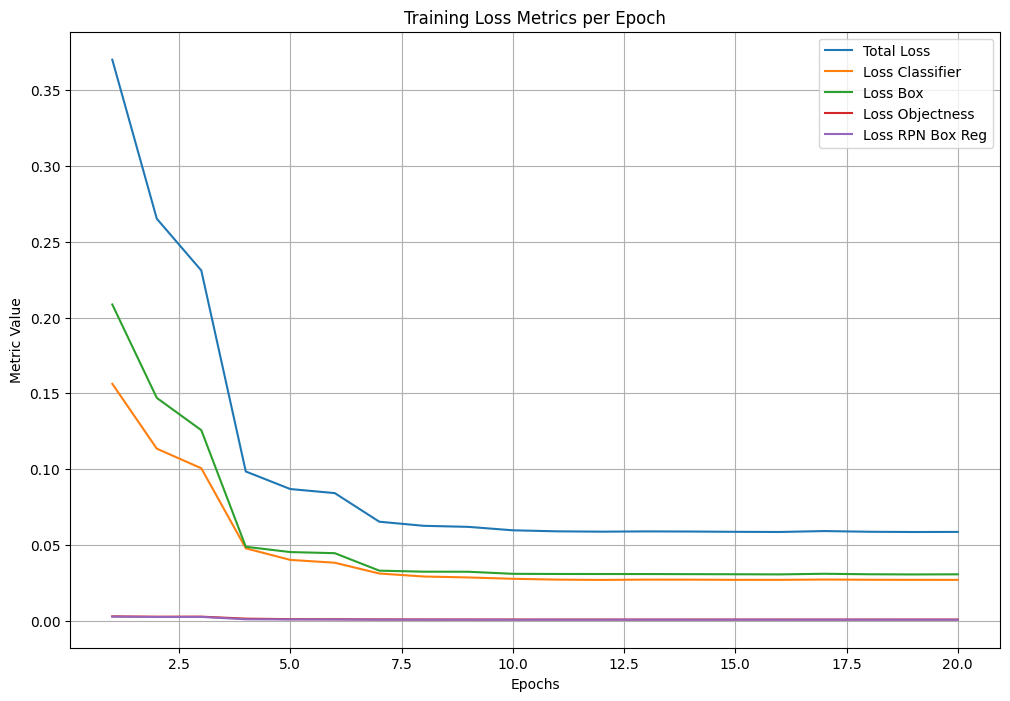

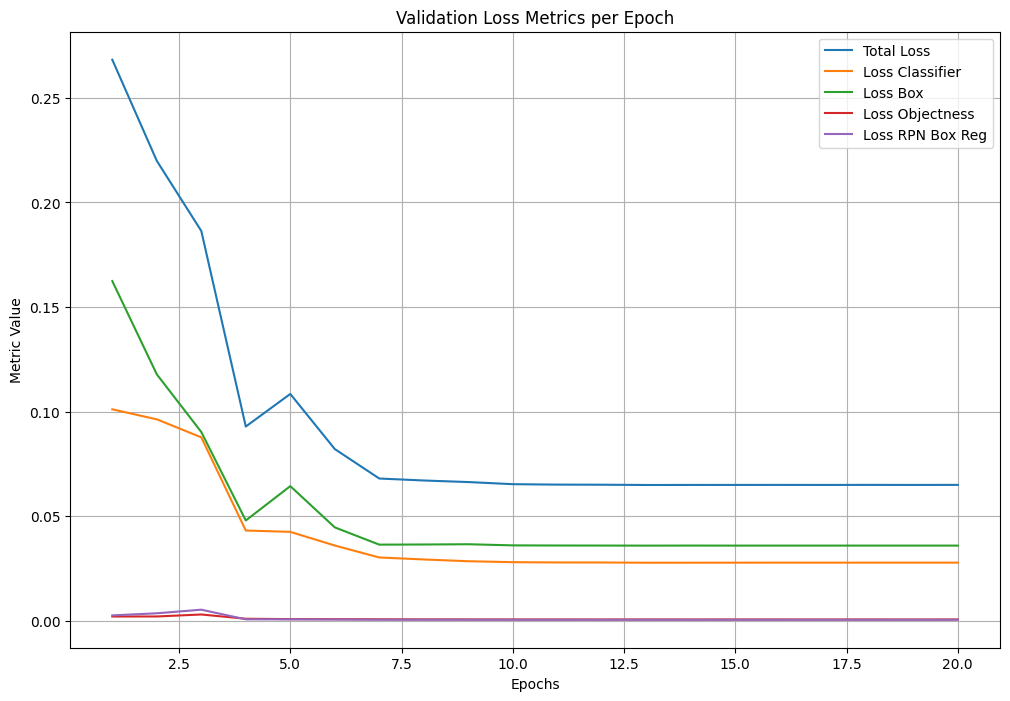

Model saved to /content/gdrive/MyDrive/Colab Notebooks/Data/LOW COMPLEXITY - Fully trained model/FasterRCNN/fasterrcnn_model_T4_low.pth


In [ ]:
# MODEL TRAINING:

import os
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN_MobileNet_V3_Large_FPN_Weights
from torchvision.transforms import transforms
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt

class CustomDataset(torch.utils.data.Dataset):
  """Custom dataset class for loading images and their corresponding annotations."""
    def __init__(self, root, transforms=None):
        self.root = root # Directory containing the images and annotations
        self.transforms = transforms # Optional transformations for the images
        self.imgs = [img for img in sorted(os.listdir(root)) if img.endswith(".png")] # List of image files

    def __getitem__(self, idx):
      """Retrieve an image and its corresponding annotation."""
        # Get image file and corresponding annotation file
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        ann_path = os.path.join(self.root, img_name.replace(".png", ".xml"))

        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(ann_path) # Parse the XML annotation file
        root = tree.getroot()

        boxes = []
        labels = []
        for member in root.findall('object'):
            labels.append(int(member.find('name').text)) # Get the label
            xmin = int(member.find('bndbox/xmin').text) # Get the bounding box coordinates
            ymin = int(member.find('bndbox/ymin').text)
            xmax = int(member.find('bndbox/xmax').text)
            ymax = int(member.find('bndbox/ymax').text)
            boxes.append([xmin, ymin, xmax, ymax]) # Add the bounding box to the list

        boxes = torch.as_tensor(boxes, dtype=torch.float32) # Convert boxes to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64) # Convert labels to tensor

        image_id = torch.tensor([idx]) # Create a tensor for the image ID
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # Calculate the area of each box
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {} # Create a target dictionary
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img) # Apply transformations

        return img, target # Return the image and its target

    def __len__(self):
      """Return the total number of images."""
        return len(self.imgs)

def get_transform():
  """Return the transformations to be applied to the images."""
    return transforms.Compose([transforms.ToTensor()])

def get_model(num_classes):
  """Load a pre-trained Faster R-CNN model and modify it for the given number of classes."""
    weights = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
    model = fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def evaluate(model, data_loader, device):
  """Evaluate the model on the validation dataset."""
    model.train()  # Temporarily switch to training mode to calculate the loss
    loss_total = 0
    loss_classifier_total = 0
    loss_box_total = 0
    loss_objectness_total = 0
    loss_rpn_box_reg_total = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            # Accumulate losses
            loss_total += sum(loss for loss in loss_dict.values()).item()
            loss_classifier_total += loss_dict['loss_classifier'].item()
            loss_box_total += loss_dict['loss_box_reg'].item()
            loss_objectness_total += loss_dict['loss_objectness'].item()
            loss_rpn_box_reg_total += loss_dict['loss_rpn_box_reg'].item()

    dataset_size = len(data_loader)
    return (loss_total / dataset_size,
            loss_classifier_total / dataset_size,
            loss_box_total / dataset_size,
            loss_objectness_total / dataset_size,
            loss_rpn_box_reg_total / dataset_size)

def compute_metrics(model, data_loader, device):
  """Compute evaluation metrics (mean average precision) for the model."""
    metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.75])
    model.eval()

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            metric.update(outputs, targets)

    return metric.compute()

def print_model_summary(model):
  """Print a summary of the model architecture."""
    num_params = sum(p.numel() for p in model.parameters())
    num_layers = len(list(model.parameters()))
    gflops = "Not Available"  # Estimation of GFLOPs requires additional computation or external libraries

    print(f"Model summary: {num_layers} layers, {num_params} parameters, GFLOPs: {gflops}")

def print_overall_metrics(metrics, dataset_name, loader):
  """Print overall evaluation metrics for the dataset."""
    overall_metrics = {
        'mAP_50': metrics['map_50'].item(),
        'mAP_75': metrics['map_75'].item(),
        'mAP_50-95': metrics['map'].item()
    }

    print(f"\nOverall Metrics ({dataset_name}):")
    print(f"Class     Images  Instances  mAP50  mAP75  mAP50-95")
    print(f"all       {len(loader.dataset)}       1      {overall_metrics['mAP_50']:.3f}  {overall_metrics['mAP_75']:.3f}  {overall_metrics['mAP_50-95']:.3f}")

def plot_metrics(metrics_history, title):
  """Plot training and validation metrics over epochs."""
    epochs = range(1, len(metrics_history) + 1)
    plt.figure(figsize=(12, 8))

    for metric_name in metrics_history[0].keys():
        metric_values = [metrics[metric_name] for metrics in metrics_history]
        plt.plot(epochs, metric_values, label=metric_name)

    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def save_model(model, path):
  """Save the trained model to the specified path."""
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def main():
  """Main training function."""
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # Use GPU if available
    num_classes = 6  # 5 classes + 1 background

    train_dataset = CustomDataset('/content/Datasets/training_XML', transforms=get_transform())
    val_dataset = CustomDataset('/content/Datasets/validation_XML', transforms=get_transform())

    # Specifie loaders for training and validation
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=lambda x: tuple(zip(*x)))

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=lambda x: tuple(zip(*x)))

    model = get_model(num_classes)
    model.to(device)

    # Specify training parameters
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    num_epochs = 20

    train_metrics_history = []
    val_metrics_history = []

    # Perform training by epoch and collect necessary metrics
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_loss_classifier = 0
        train_loss_box = 0
        train_loss_objectness = 0
        train_loss_rpn_box_reg = 0

        loop = tqdm(train_loader, leave=True)
        for images, targets in loop:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            train_loss += losses.item()
            train_loss_classifier += loss_dict['loss_classifier'].item()
            train_loss_box += loss_dict['loss_box_reg'].item()
            train_loss_objectness += loss_dict['loss_objectness'].item()
            train_loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=losses.item())

        train_loss /= len(train_loader)
        train_loss_classifier /= len(train_loader)
        train_loss_box /= len(train_loader)
        train_loss_objectness /= len(train_loader)
        train_loss_rpn_box_reg /= len(train_loader)

        lr_scheduler.step()

        val_loss, val_loss_classifier, val_loss_box, val_loss_objectness, val_loss_rpn_box_reg = evaluate(model, val_loader, device)

        # Print metrics
        print(f"Training Loss: {train_loss:.6f}, Loss Classifier: {train_loss_classifier:.6f}, Loss Box: {train_loss_box:.6f}, Loss Objectness: {train_loss_objectness:.6f}, Loss RPN Box Reg: {train_loss_rpn_box_reg:.6f}")
        print(f"Validation Loss: {val_loss:.6f}, Loss Classifier: {val_loss_classifier:.6f}, Loss Box: {val_loss_box:.6f}, Loss Objectness: {val_loss_objectness:.6f}, Loss RPN Box Reg: {val_loss_rpn_box_reg:.6f}")

        train_metrics_history.append({
            'Total Loss': train_loss,
            'Loss Classifier': train_loss_classifier,
            'Loss Box': train_loss_box,
            'Loss Objectness': train_loss_objectness,
            'Loss RPN Box Reg': train_loss_rpn_box_reg
        })
        val_metrics_history.append({
            'Total Loss': val_loss,
            'Loss Classifier': val_loss_classifier,
            'Loss Box': val_loss_box,
            'Loss Objectness': val_loss_objectness,
            'Loss RPN Box Reg': val_loss_rpn_box_reg
        })

    # Print final summaries and plots
    print_model_summary(model)
    train_metrics = compute_metrics(model, train_loader, device)
    val_metrics = compute_metrics(model, val_loader, device)
    print_overall_metrics(train_metrics, "Training", train_loader)
    print_overall_metrics(val_metrics, "Validation", val_loader)

    print("\n")
    plot_metrics(train_metrics_history, "Training Loss Metrics per Epoch")
    print("\n")
    plot_metrics(val_metrics_history, "Validation Loss Metrics per Epoch")

    # Save the model to Google Drive
    save_model(model, '/content/gdrive/MyDrive/Colab Notebooks/Data/LOW COMPLEXITY - Fully trained model/FasterRCNN/fasterrcnn_model_T4_low.pth')

if __name__ == "__main__":
    main()

# **INFERENCE:**

### **SYNTHETIC TESTING DATASET:**

In [ ]:
# PERFORM INFERENCE USING PREVIOUSLY TRAINED MODEL:

import torch
from torchvision.transforms import transforms
from PIL import Image
import os
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm
from torchvision.models.detection.faster_rcnn import FasterRCNN_MobileNet_V3_Large_FPN_Weights

# Class mapping starting from 1
class_mapping = {
    'D1098590': 1,
    'D1100844': 2,
    'D1612695': 3,
    'D1899542': 4,
    'D4332268': 5,
}

# Reverse the class mapping for easier lookup by class index
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

class CustomDatasetTest(torch.utils.data.Dataset):
  """Custom dataset class for loading test images without annotations."""
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = [img for img in sorted(os.listdir(root)) if img.endswith(".png")]

    def __getitem__(self, idx):
      """Retrieve an image and its corresponding name."""
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)

        img = Image.open(img_path).convert("RGB")

        if self.transforms:
            img = self.transforms(img)

        return img, img_name

    def __len__(self):
      """Return the total number of images."""
        return len(self.imgs)

def get_transform():
  """Return the transformations to be applied to the images."""
    return transforms.Compose([transforms.ToTensor()])

def get_model(num_classes):
  """Load a pre-trained Faster R-CNN model and modify it for the given number of classes."""
    weights = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
    model = fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def load_model(model_path, num_classes):
  """Load the trained model from the specified path."""
    model = get_model(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def save_yolo_format(output_path, img_name, box, label, score, img_width, img_height):
  """Save the detected bounding box in YOLO format."""
    base_name = os.path.splitext(img_name)[0]  # Extract base name without extension
    txt_path = os.path.join(output_path, base_name + '.txt')
    with open(txt_path, 'w') as f:
        xmin, ymin, xmax, ymax = box
        x_center = (xmin + xmax) / 2.0 / img_width
        y_center = (ymin + ymax) / 2.0 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height
        f.write(f"{label - 1} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")  # Adjust label to start from 0

def main():
  """Main inference function"""
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    num_classes = len(class_mapping) + 1  # Number of classes (including background)

    # Load the saved model
    model_path = '/content/gdrive/MyDrive/Colab Notebooks/Data/LOW COMPLEXITY - Fully trained model/FasterRCNN/fasterrcnn_model_T4_low.pth'
    model = load_model(model_path, num_classes)
    model.to(device)

    # Prepare the test dataset
    test_dataset = CustomDatasetTest('/content/Datasets/synthetic_testing', transforms=get_transform())
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

    output_path = '/content/Datasets/synthetic_testing_results'  # Folder to save YOLO format annotations
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Perform inference and save results
    for images, img_names in tqdm(test_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for img, output, img_name in zip(images, outputs, img_names):
            img = img.permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and change the dimensions
            img_height, img_width, _ = img.shape
            boxes = output['boxes'].cpu().detach().numpy()
            labels = output['labels'].cpu().detach().numpy()
            scores = output['scores'].cpu().detach().numpy()

            # Select the box with the highest score
            max_score_idx = scores.argmax()
            max_score_box = boxes[max_score_idx]
            max_score_label = labels[max_score_idx]
            max_score = scores[max_score_idx]

            save_yolo_format(output_path, img_name, max_score_box, max_score_label, max_score, img_width, img_height)

if __name__ == "__main__":
    main()

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 49.2MB/s]
  0%|          | 0/1000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [00:27<00:00, 36.02it/s]


In [ ]:
# COMPARE ANNOTATION FILES:

import os
import numpy as np
from PIL import Image
from collections import defaultdict

# Class mapping starting from 0 (because the generated annotations are in YOLO format, they start with 0)
class_mapping = {
    'D1098590': 0,
    'D1100844': 1,
    'D1612695': 2,
    'D1899542': 3,
    'D4332268': 4,
}

# Reverse the class mapping for easier lookup by class index
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

def parse_yolo_annotation(txt_file, img_width, img_height):
  """Parse YOLO format annotation file to extract bounding boxes and labels."""
    boxes = []
    labels = []

    with open(txt_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            label = int(data[0])
            x_center = float(data[1]) * img_width
            y_center = float(data[2]) * img_height
            width = float(data[3]) * img_width
            height = float(data[4]) * img_height
            xmin = int(x_center - width / 2)
            ymin = int(y_center - height / 2)
            xmax = int(x_center + width / 2)
            ymax = int(y_center + height / 2)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

    return boxes, labels

def calculate_iou(box1, box2):
  """Calculate Intersection over Union (IoU) between two bounding boxes."""
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    if inter_x_max < inter_x_min or inter_y_max < inter_y_min:
        return 0.0

    inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def compare_annotations(real_dir, inferred_dir, img_dir, iou_threshold=0.5):
  """Compare real and inferred annotations, calculating classification accuracy and IoU."""
    real_files = [f for f in os.listdir(real_dir) if f.endswith('.txt')]
    inferred_files = [f for f in os.listdir(inferred_dir) if f.endswith('.txt')]

    total_files = len(real_files)
    correct_classifications = defaultdict(int)
    incorrect_classifications = defaultdict(int)
    total_iou_per_class = defaultdict(float)
    total_matches_per_class = defaultdict(int)
    classes = set()

    for real_file in real_files:
        base_name = real_file.replace('.txt', '')
        inferred_file = base_name + '.txt'
        img_file = base_name + '.png'

        if inferred_file not in inferred_files:
            print(f"Skipping {real_file}: no corresponding inferred file")
            continue

        img_path = os.path.join(img_dir, img_file)
        if not os.path.exists(img_path):
            print(f"Skipping {real_file}: no corresponding image file")
            continue

        img = Image.open(img_path)
        img_width, img_height = img.size

        real_boxes, real_labels = parse_yolo_annotation(os.path.join(real_dir, real_file), img_width, img_height)
        inferred_boxes, inferred_labels = parse_yolo_annotation(os.path.join(inferred_dir, inferred_file), img_width, img_height)

        #print(f"Processing {real_file} with {len(real_boxes)} real boxes and {len(inferred_boxes)} inferred boxes")

        for r_box, r_label in zip(real_boxes, real_labels):
            classes.add(r_label)
            best_iou = 0.0
            best_match_idx = -1

            for idx, (i_box, i_label) in enumerate(zip(inferred_boxes, inferred_labels)):
                if r_label == i_label:
                    iou = calculate_iou(r_box, i_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_match_idx = idx

            if best_iou >= iou_threshold:
                correct_classifications[r_label] += 1
                total_iou_per_class[r_label] += best_iou
                total_matches_per_class[r_label] += 1
                del inferred_boxes[best_match_idx]
                del inferred_labels[best_match_idx]
            else:
                incorrect_classifications[r_label] += 1

    # Calculate metrics
    overall_correct = sum(correct_classifications.values())
    overall_incorrect = sum(incorrect_classifications.values())
    overall_total_iou = sum(total_iou_per_class.values())
    overall_total_matches = sum(total_matches_per_class.values())
    overall_avg_iou = overall_total_iou / overall_total_matches if overall_total_matches > 0 else 0.0

    # Print metrics
    for label in sorted(classes):
        class_name = reverse_class_mapping.get(label, "Unknown")
        avg_iou = total_iou_per_class[label] / total_matches_per_class[label] if total_matches_per_class[label] > 0 else 0.0
        print(f"Class {label} ({class_name}):")
        print(f"  Correct classifications: {correct_classifications[label]}")
        print(f"  Incorrect classifications: {incorrect_classifications[label]}")
        print(f"  Classification accuracy: {(correct_classifications[label] / (correct_classifications[label] + incorrect_classifications[label])) * 100:.2f}%")
        print(f"  Average IoU: {avg_iou:.4f}")

    print("\nOverall:")
    print(f"  Total files: {total_files}")
    print(f"  Correct classifications: {overall_correct}")
    print(f"  Incorrect classifications: {overall_incorrect}")
    print(f"  Classification accuracy: {(overall_correct / total_files) * 100:.2f}%")
    print(f"  Average IoU: {overall_avg_iou:.4f}")

# Perform comparison
annotations_and_images_dir = '/content/Datasets/synthetic_testing'
inferred_annotations_dir = '/content/Datasets/synthetic_testing_results'

compare_annotations(annotations_and_images_dir, inferred_annotations_dir, annotations_and_images_dir)

Class 0 (D1098590):
  Correct classifications: 200
  Incorrect classifications: 0
  Classification accuracy: 100.00%
  Average IoU: 0.9791
Class 1 (D1100844):
  Correct classifications: 200
  Incorrect classifications: 0
  Classification accuracy: 100.00%
  Average IoU: 0.9750
Class 2 (D1612695):
  Correct classifications: 167
  Incorrect classifications: 33
  Classification accuracy: 83.50%
  Average IoU: 0.9677
Class 3 (D1899542):
  Correct classifications: 37
  Incorrect classifications: 163
  Classification accuracy: 18.50%
  Average IoU: 0.9801
Class 4 (D4332268):
  Correct classifications: 199
  Incorrect classifications: 1
  Classification accuracy: 99.50%
  Average IoU: 0.9598

Overall:
  Total files: 1000
  Correct classifications: 803
  Incorrect classifications: 197
  Classification accuracy: 80.30%
  Average IoU: 0.9710


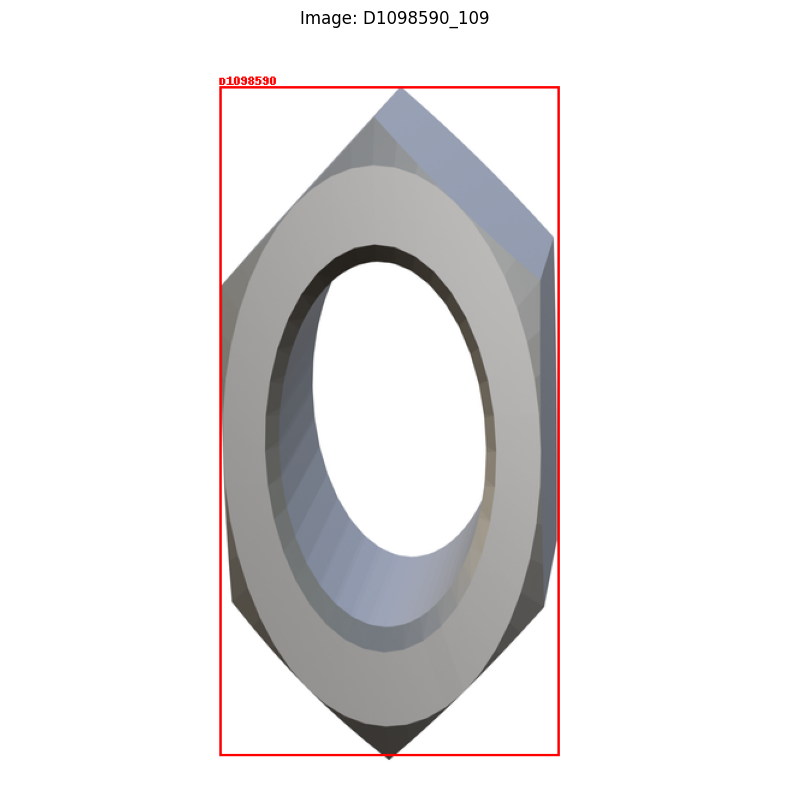

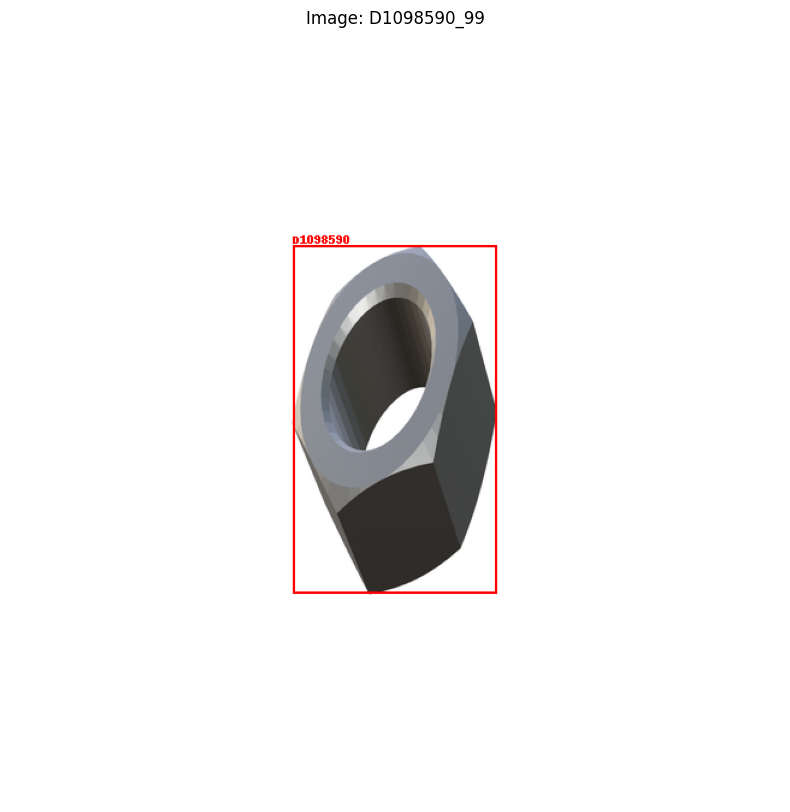

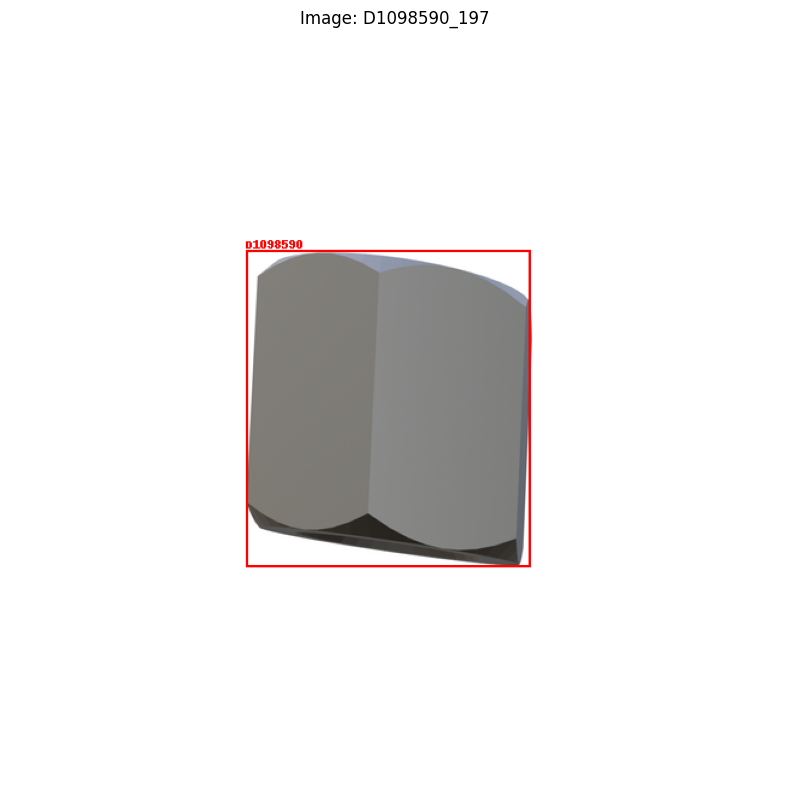

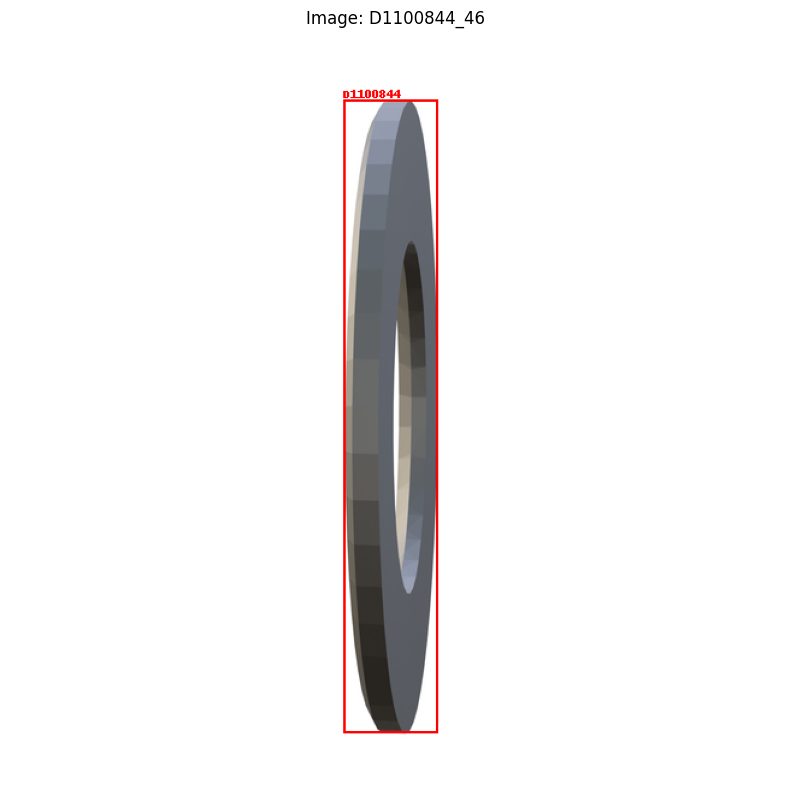

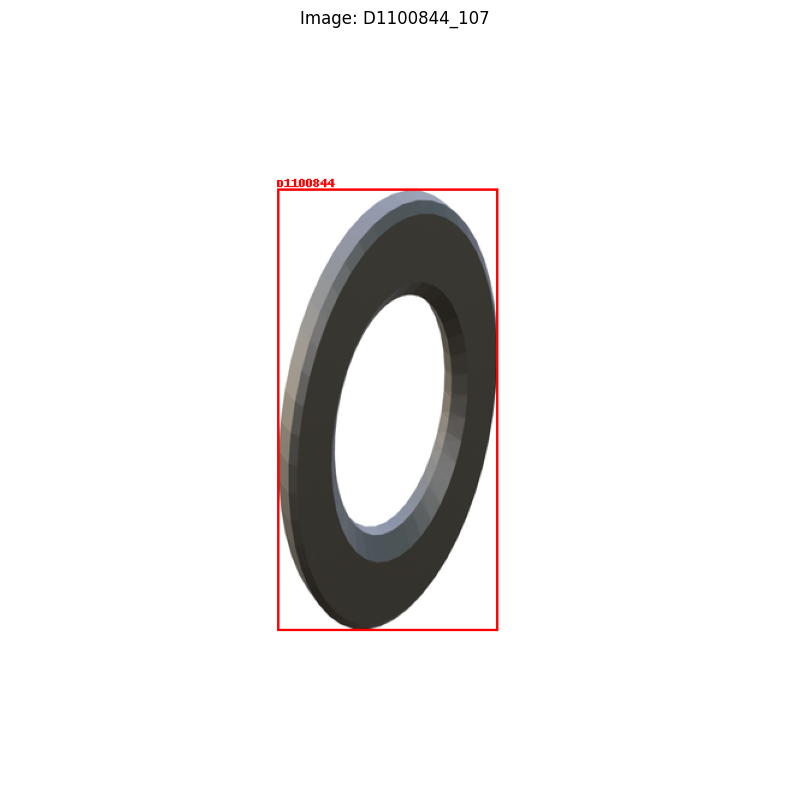

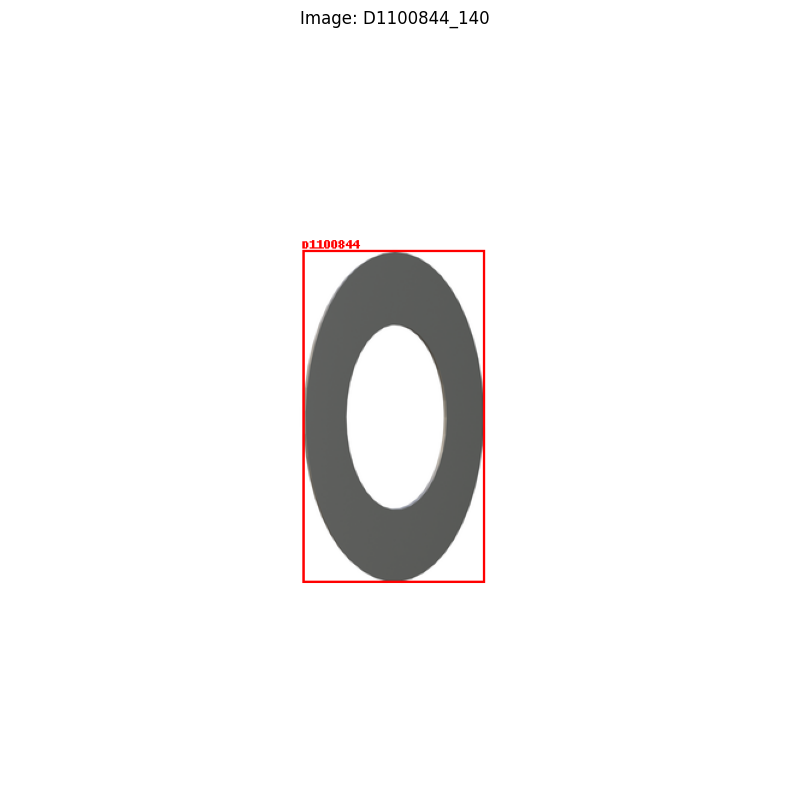

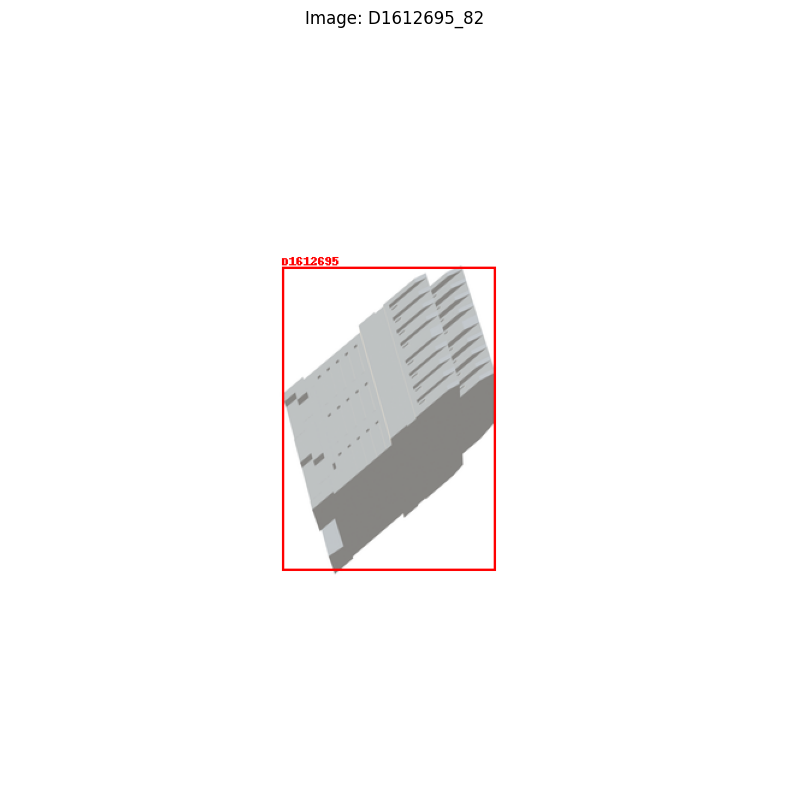

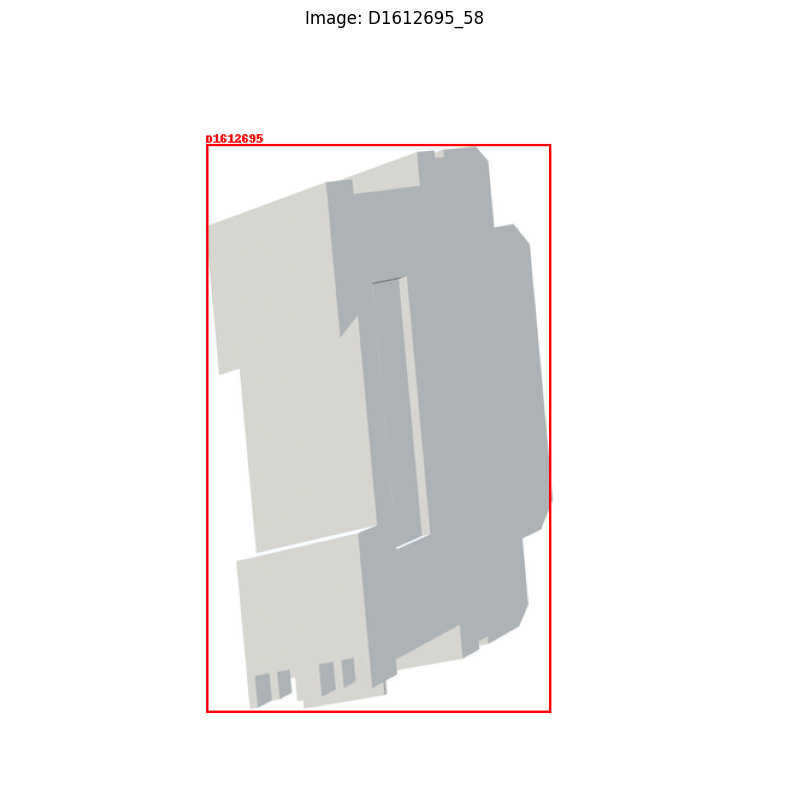

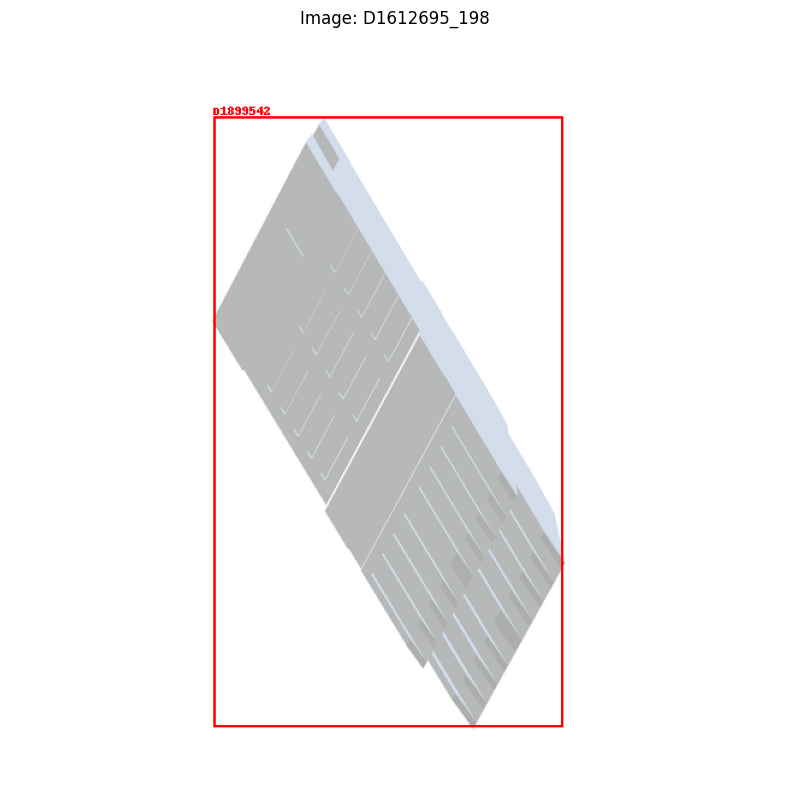

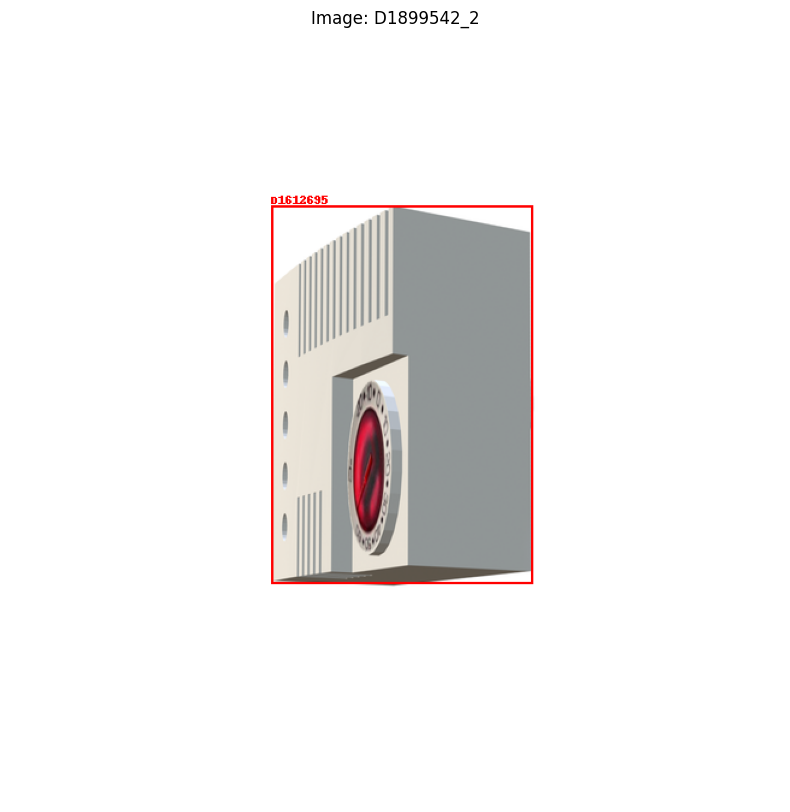

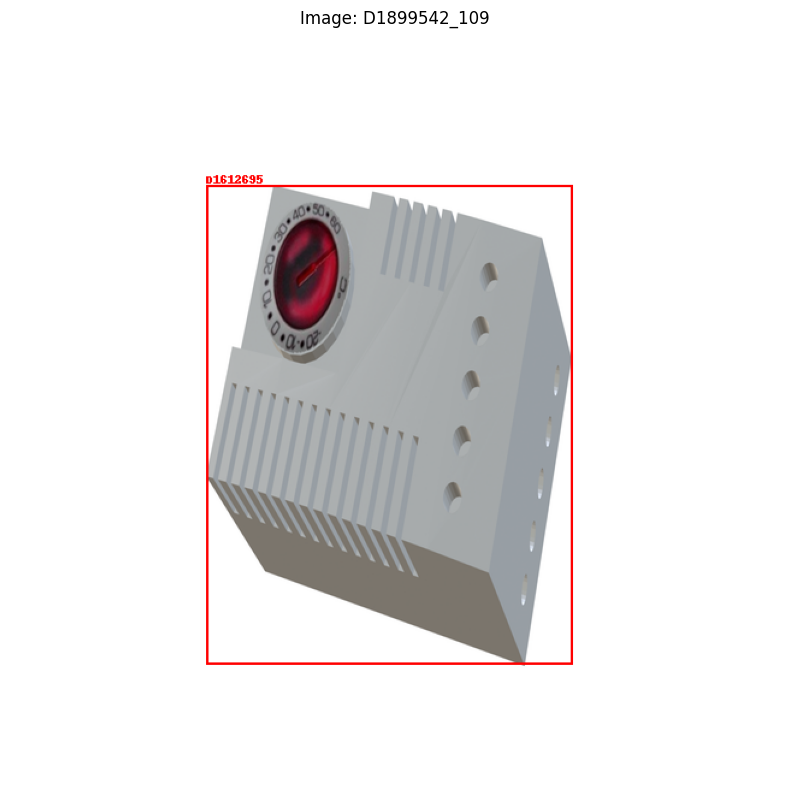

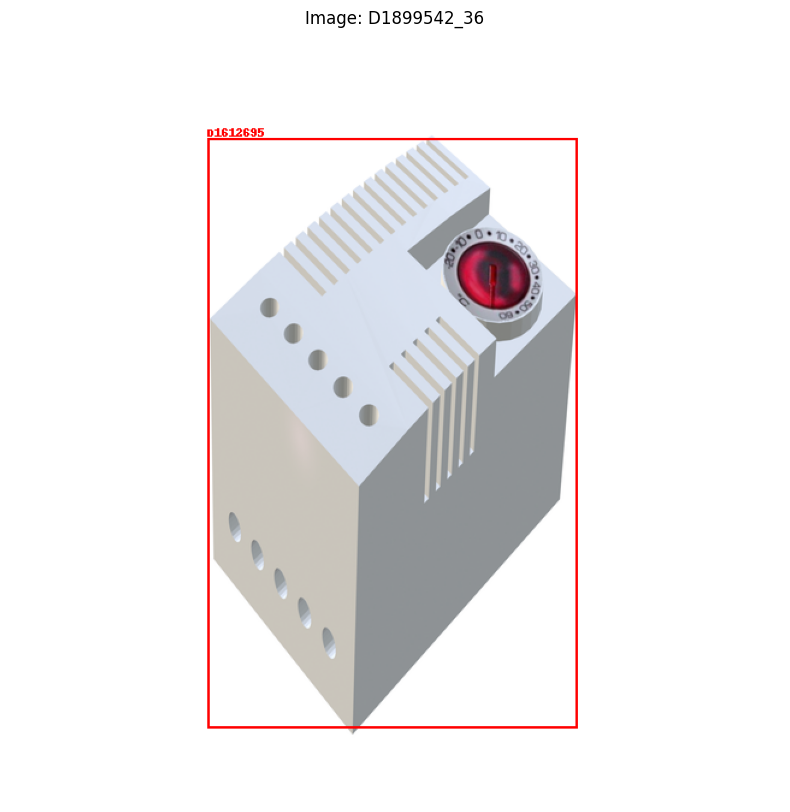

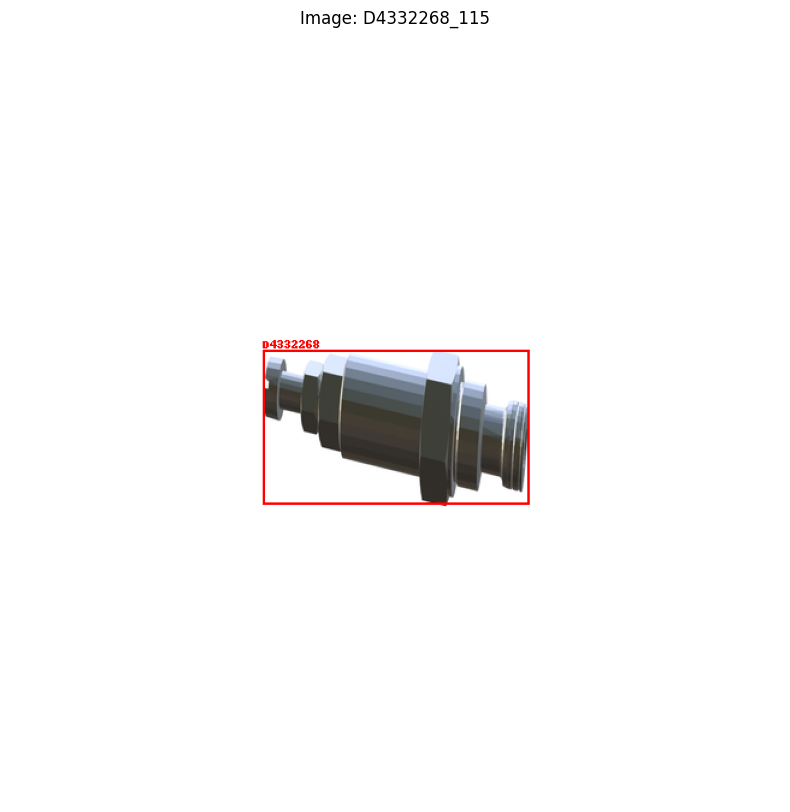

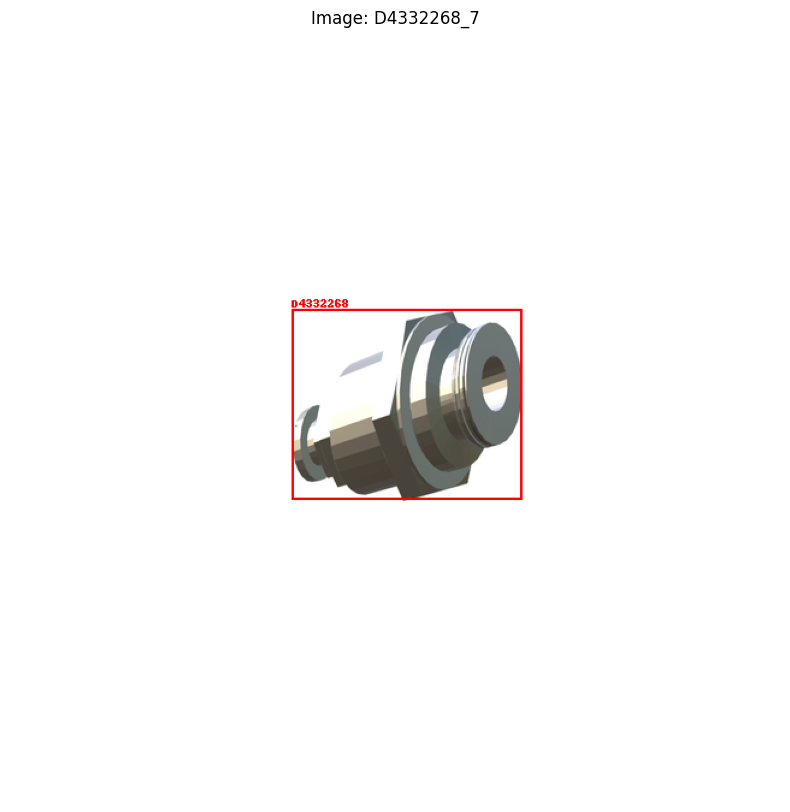

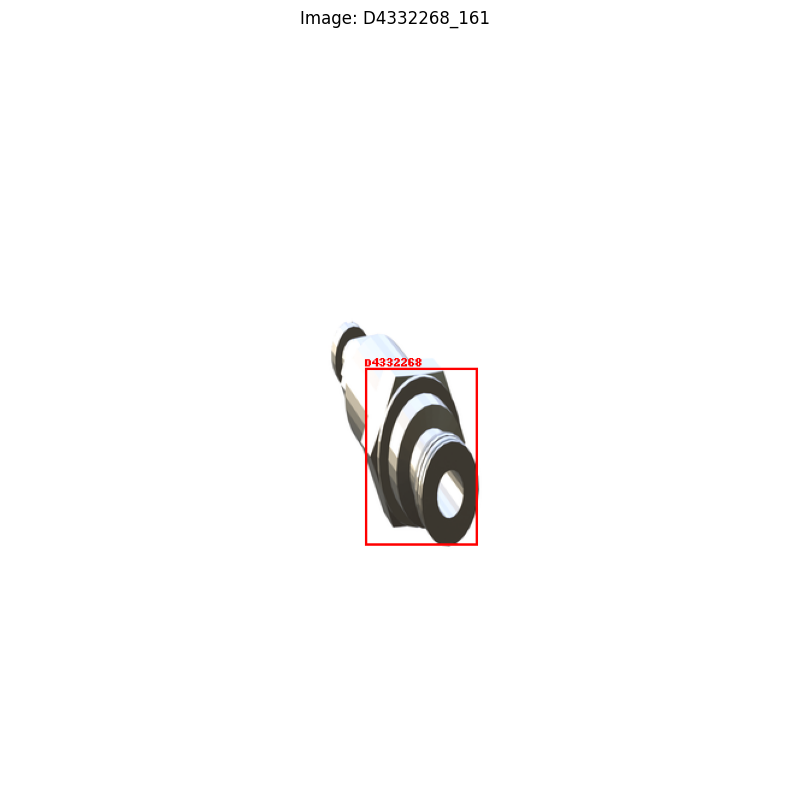

In [ ]:
# VISUALIZE:

import os
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import defaultdict

# Class mapping starting from 0
class_mapping = {
    'D1098590': 0,
    'D1100844': 1,
    'D1612695': 2,
    'D1899542': 3,
    'D4332268': 4,
}

# Reverse the class mapping for easier lookup by class index
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

def parse_yolo_annotation(txt_file, img_width, img_height):
    boxes = []
    labels = []

    with open(txt_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            label = int(data[0])
            x_center = float(data[1]) * img_width
            y_center = float(data[2]) * img_height
            width = float(data[3]) * img_width
            height = float(data[4]) * img_height
            xmin = int(x_center - width / 2)
            ymin = int(y_center - height / 2)
            xmax = int(x_center + width / 2)
            ymax = int(y_center + height / 2)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

    return boxes, labels

def visualize_images_with_annotations(img_dir, inferred_dir, num_images_per_class=3):
    img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
    class_to_files = defaultdict(list)

    # Group images by class based on filename
    for img_file in img_files:
        class_name_from_file = img_file[:8]
        if class_name_from_file in class_mapping:
            label = class_mapping[class_name_from_file]
            class_to_files[label].append(img_file)

    # Select random images for each class and sort by class order
    selected_files = []
    for label in sorted(class_to_files.keys()):
        files = class_to_files[label]
        selected_files.extend(random.sample(files, min(num_images_per_class, len(files))))

    # Load a font
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except IOError:
        font = ImageFont.load_default()

    # Visualize selected images with annotations
    for img_file in selected_files:
        base_name = img_file.replace('.png', '')
        inferred_file = base_name + '.txt'

        img_path = os.path.join(img_dir, img_file)
        inferred_path = os.path.join(inferred_dir, inferred_file)

        img = Image.open(img_path)
        img_width, img_height = img.size

        inferred_boxes, inferred_labels = parse_yolo_annotation(inferred_path, img_width, img_height)

        draw = ImageDraw.Draw(img)
        for box, label in zip(inferred_boxes, inferred_labels):
            xmin, ymin, xmax, ymax = box
            draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=2)
            class_name = reverse_class_mapping.get(label, "Unknown")
            text_position = (xmin, ymin - 10)
            draw.text(text_position, class_name, fill='red', font=font)  # Move class name above the box and make it bigger

        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(f"Image: {base_name}")
        plt.axis('off')
        plt.show()

# Perform visualization
img_dir = '/content/Datasets/synthetic_testing'
inferred_dir = '/content/Datasets/synthetic_testing_results'

visualize_images_with_annotations(img_dir, inferred_dir)

### **REAL TESTING DATASET (internet imagery):**

In [ ]:
# PERFORM INFERENCE ON A TRADITIONAL (REAL) DATASET

import torch
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import transforms
from collections import defaultdict

# Class mapping starting from 0
class_mapping = {
    'D1098590': 0,
    'D1100844': 1,
    'D1612695': 2,
    'D1899542': 3,
    'D4332268': 4,
}

# Reverse the class mapping for easier lookup by class index
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

class CustomDatasetTest(torch.utils.data.Dataset):
  """Custom dataset class for loading test images without annotations."""
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = [f for f in os.listdir(root) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __getitem__(self, idx):
      """Retrieve an image and its corresponding name."""
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        img_name = self.imgs[idx]

        if self.transforms is not None:
            img = self.transforms(img)

        return img, img_name

    def __len__(self):
      """Return the total number of images."""
        return len(self.imgs)

def get_transform():
  """Return the transformations to be applied to the images."""
    return transforms.Compose([transforms.ToTensor()])

def get_model(num_classes):
  """Load a pre-trained Faster R-CNN model and modify it for the given number of classes."""
    weights = fasterrcnn_mobilenet_v3_large_fpn(weights='DEFAULT')
    model = fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def load_model(model_path, num_classes):
  """Load the trained model from the specified path."""
    model = get_model(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def save_yolo_format(output_path, img_name, box=None, label=None, score=None, img_width=None, img_height=None):
  """Save the detected bounding box in YOLO format."""
    base_name = os.path.splitext(img_name)[0]  # Extract base name without extension
    txt_path = os.path.join(output_path, base_name + '.txt')
    with open(txt_path, 'w') as f:
        if box is None:
            f.write("undetected inside\n")
        else:
            xmin, ymin, xmax, ymax = box
            x_center = (xmin + xmax) / 2.0 / img_width
            y_center = (ymin + ymax) / 2.0 / img_height
            width = (xmax - xmin) / img_width
            height = (ymax - ymin) / img_height
            f.write(f"{label - 1} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")  # Adjust label to start from 0

def main():
  """Main inference function."""
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    num_classes = len(class_mapping) + 1  # Number of classes (including background)

    # Load the saved model
    model_path = '/content/gdrive/MyDrive/Colab Notebooks/Data/LOW COMPLEXITY - Fully trained model/FasterRCNN/fasterrcnn_model_T4_low.pth'
    model = load_model(model_path, num_classes)
    model.to(device)

    # Prepare the test dataset
    test_dataset = CustomDatasetTest('/content/Datasets/actual_testing', transforms=get_transform())
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

    output_path = '/content/Datasets/actual_testing_results'  # Folder to save YOLO format annotations
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Perform inference and save results
    for images, img_names in tqdm(test_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for img, output, img_name in zip(images, outputs, img_names):
            img = img.permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and change the dimensions
            img_height, img_width, _ = img.shape
            boxes = output['boxes'].cpu().detach().numpy()
            labels = output['labels'].cpu().detach().numpy()
            scores = output['scores'].cpu().detach().numpy()

            if scores.size == 0:
                print(f"No detections found for image {img_name}")
                save_yolo_format(output_path, img_name)
                continue

            # Select the box with the highest score
            max_score_idx = scores.argmax()
            max_score_box = boxes[max_score_idx]
            max_score_label = labels[max_score_idx]
            max_score = scores[max_score_idx]

            save_yolo_format(output_path, img_name, max_score_box, max_score_label, max_score, img_width, img_height)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 85/85 [00:02<00:00, 33.10it/s]


In [ ]:
# PERFORM COMPARISON

import os
from collections import defaultdict

# Class mapping
class_mapping = {
    'D1098590': 0,
    'D1100844': 1,
    'D1612695': 2,
    'D1899542': 3,
    'D4332268': 4,
}

# Reverse the class mapping for easier lookup by class index
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

def parse_yolo_annotation(txt_file):
  """Parse YOLO format annotation file to extract labels."""
    labels = []

    with open(txt_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            if data[0].isdigit():  # Check if the label is a digit
                label = int(data[0])
                labels.append(label)
            else:
                labels.append("undetected")

    return labels

def compare_annotations(inferred_dir):
  """Comparing inferred annotations with correct classes, calculating classification accuracy."""
    inferred_files = [f for f in os.listdir(inferred_dir) if f.endswith('.txt')]

    total_files = len(inferred_files)
    correct_classifications = defaultdict(int)
    incorrect_classifications = defaultdict(int)
    undetected_classifications = defaultdict(int)
    classes = set()

    for inferred_file in inferred_files:
        base_name = inferred_file.replace('.txt', '')
        class_name_from_file = base_name[:8]
        inferred_path = os.path.join(inferred_dir, inferred_file)

        if class_name_from_file not in class_mapping:
            print(f"Skipping {inferred_file}: class name not in mapping")
            continue

        expected_label = class_mapping[class_name_from_file]
        inferred_labels = parse_yolo_annotation(inferred_path)

        if not inferred_labels or inferred_labels[0] == "undetected":
            undetected_classifications[expected_label] += 1
            continue

        inferred_label = inferred_labels[0]  # assuming only one label per file

        classes.add(expected_label)

        if expected_label == inferred_label:
            correct_classifications[expected_label] += 1
        else:
            incorrect_classifications[expected_label] += 1

    # Calculate metrics
    overall_correct = sum(correct_classifications.values())
    overall_incorrect = sum(incorrect_classifications.values())
    overall_undetected = sum(undetected_classifications.values())

    # Print metrics
    for label in sorted(classes):
        class_name = reverse_class_mapping.get(label, "Unknown")
        total_classifications = (correct_classifications[label] +
                                 incorrect_classifications[label] +
                                 undetected_classifications[label])
        classification_accuracy = (correct_classifications[label] / total_classifications) * 100 if total_classifications > 0 else 0
        print(f"Class {label} ({class_name}):")
        print(f"  Correct classifications: {correct_classifications[label]}")
        print(f"  Incorrect classifications: {incorrect_classifications[label]}")
        print(f"  Undetected classifications: {undetected_classifications[label]}")
        print(f"  Classification accuracy: {classification_accuracy:.2f}%")

    overall_accuracy = (overall_correct / total_files) * 100 if total_files > 0 else 0
    print("\nOverall:")
    print(f"  Total files: {total_files}")
    print(f"  Correct classifications: {overall_correct}")
    print(f"  Incorrect classifications: {overall_incorrect}")
    print(f"  Undetected classifications: {overall_undetected}")
    print(f"  Classification accuracy: {overall_accuracy:.2f}%")

# Perform comparison
inferred_annotations_dir = '/content/Datasets/actual_testing_results'

compare_annotations(inferred_annotations_dir)

Class 0 (D1098590):
  Correct classifications: 3
  Incorrect classifications: 17
  Undetected classifications: 0
  Classification accuracy: 15.00%
Class 1 (D1100844):
  Correct classifications: 5
  Incorrect classifications: 15
  Undetected classifications: 0
  Classification accuracy: 25.00%
Class 2 (D1612695):
  Correct classifications: 3
  Incorrect classifications: 2
  Undetected classifications: 0
  Classification accuracy: 60.00%
Class 3 (D1899542):
  Correct classifications: 20
  Incorrect classifications: 0
  Undetected classifications: 0
  Classification accuracy: 100.00%
Class 4 (D4332268):
  Correct classifications: 2
  Incorrect classifications: 18
  Undetected classifications: 0
  Classification accuracy: 10.00%

Overall:
  Total files: 85
  Correct classifications: 33
  Incorrect classifications: 52
  Undetected classifications: 0
  Classification accuracy: 38.82%


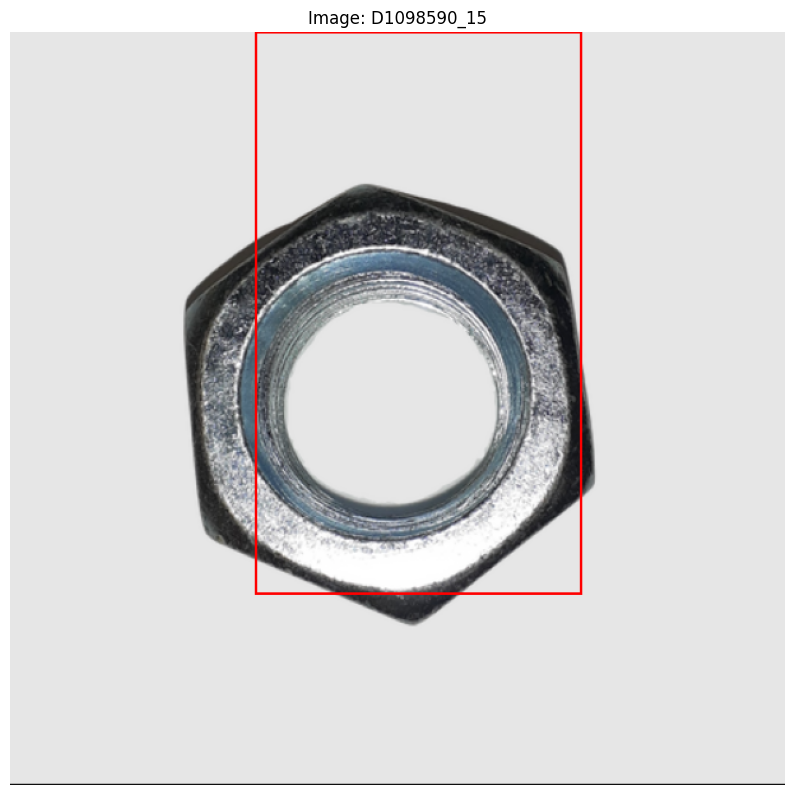

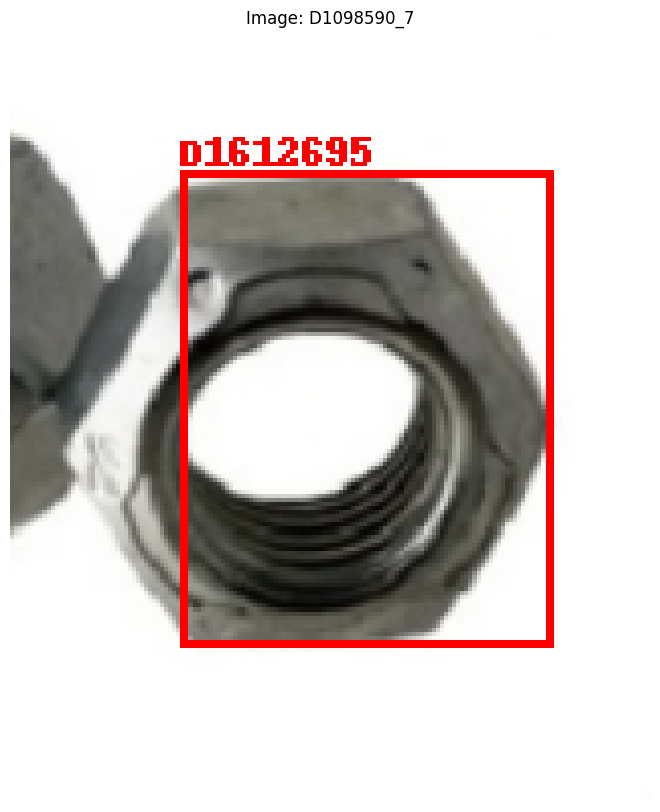

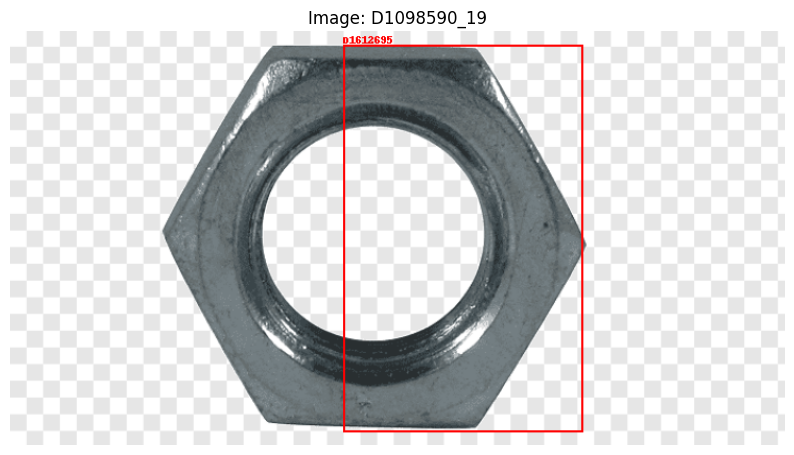

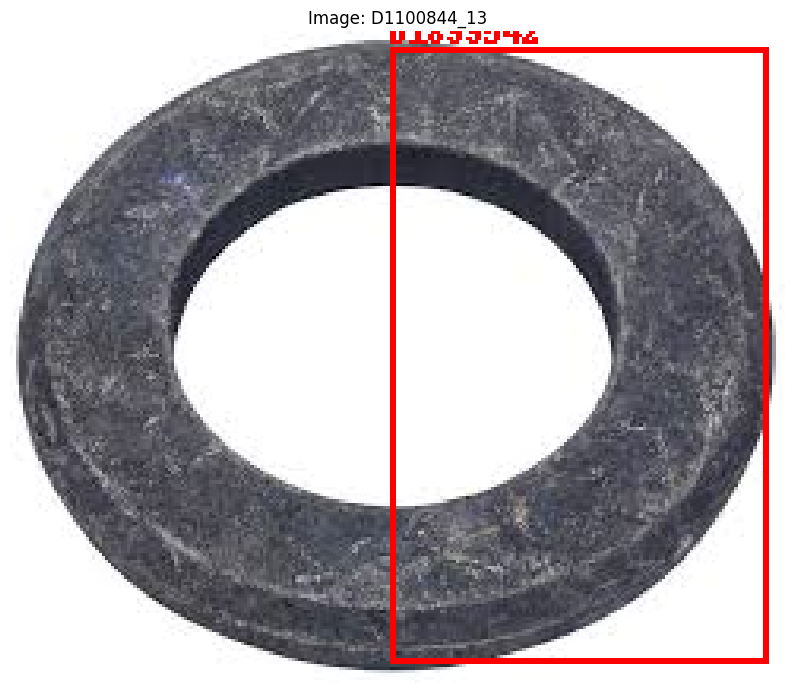

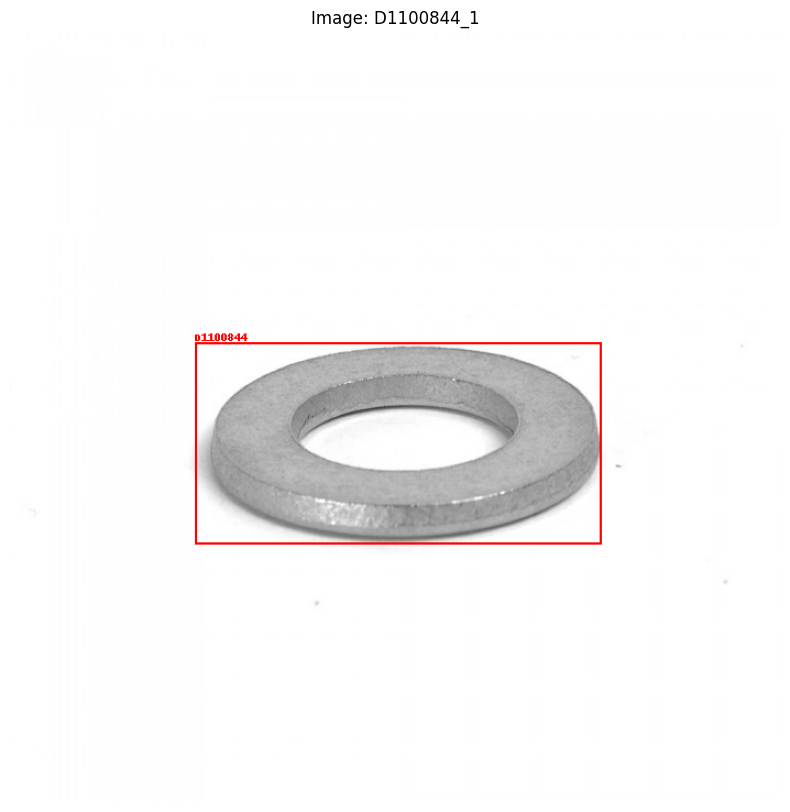

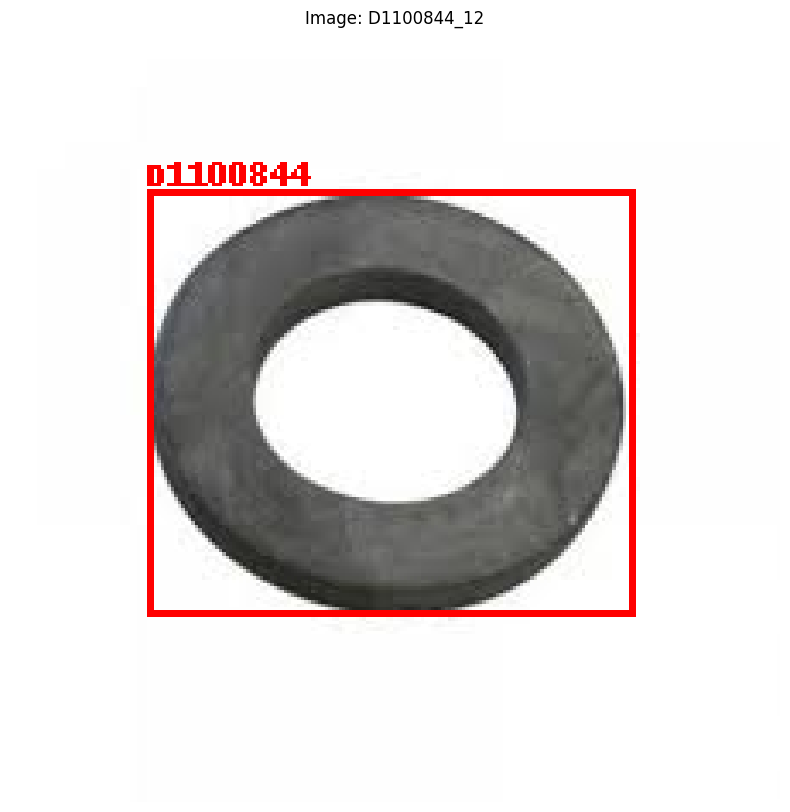

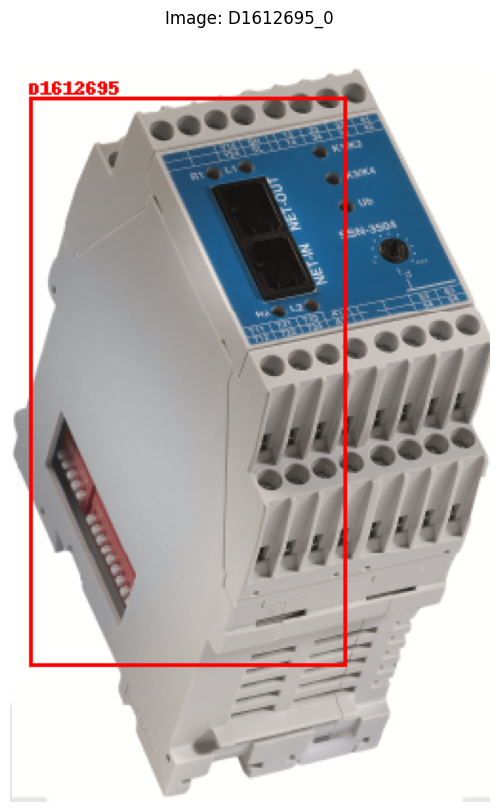

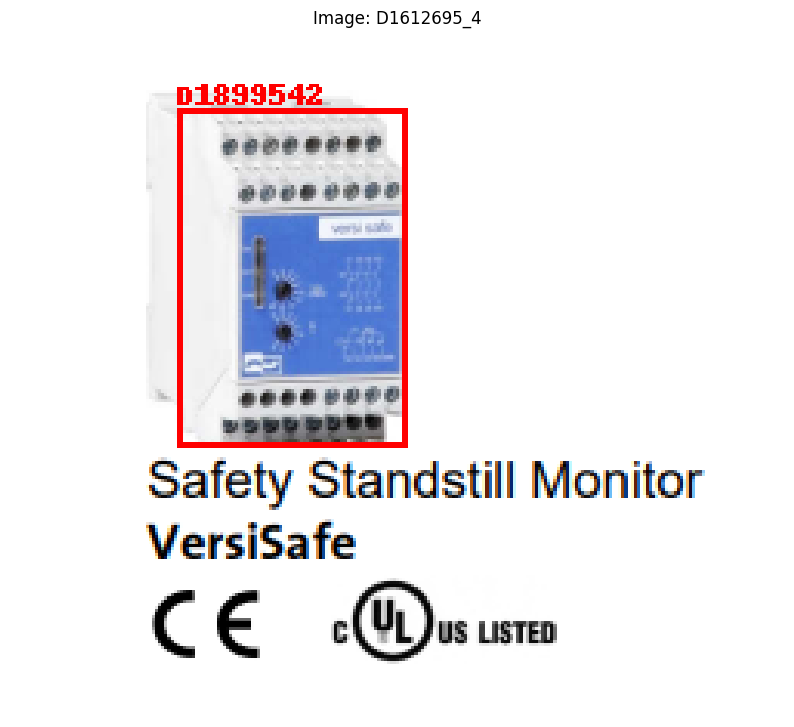

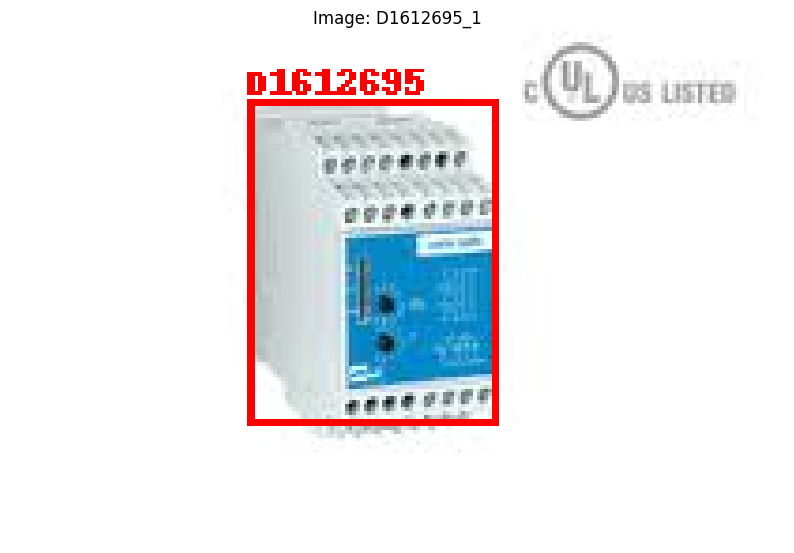

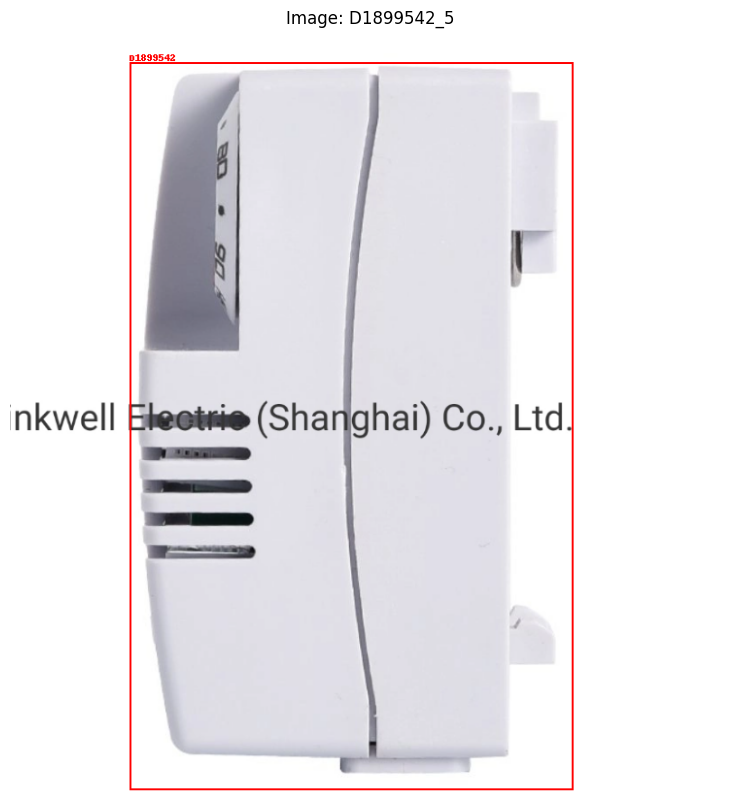

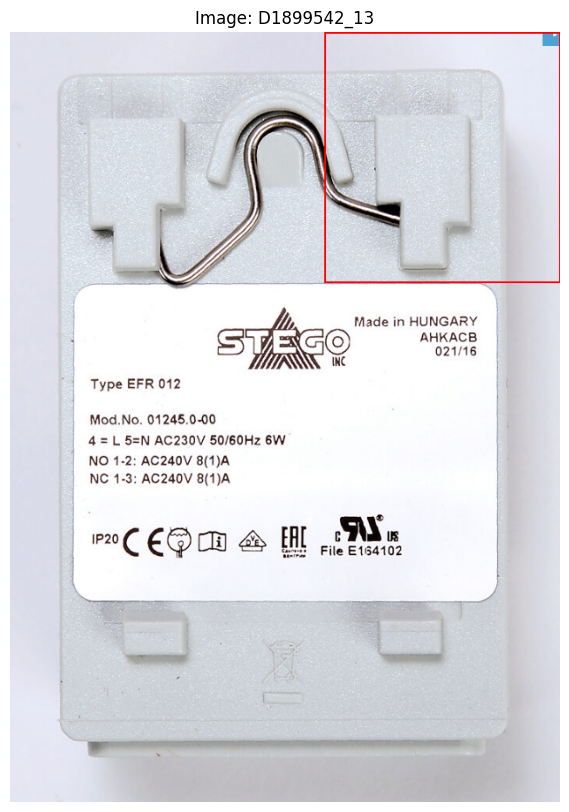

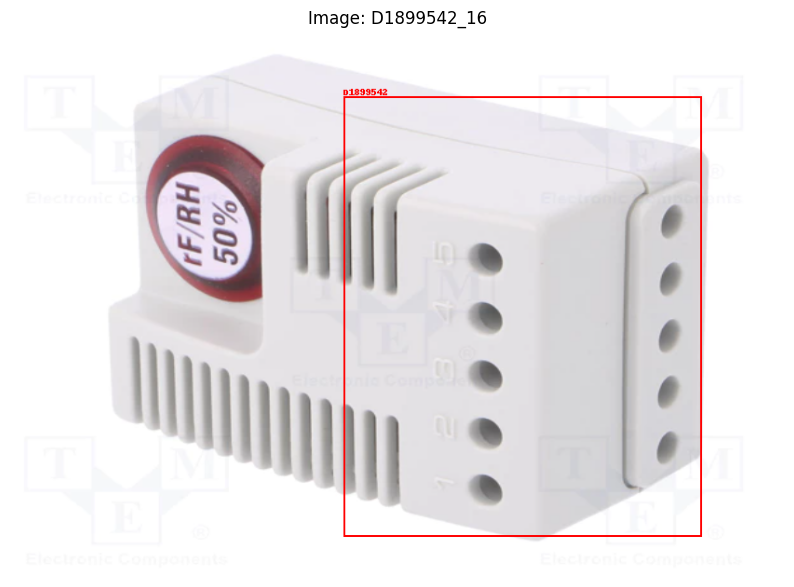

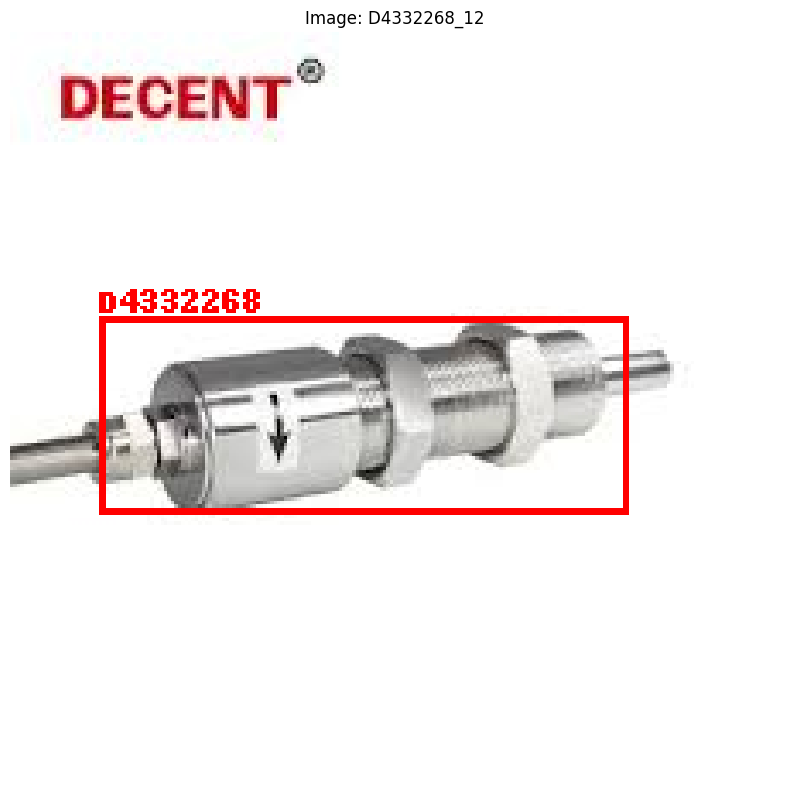

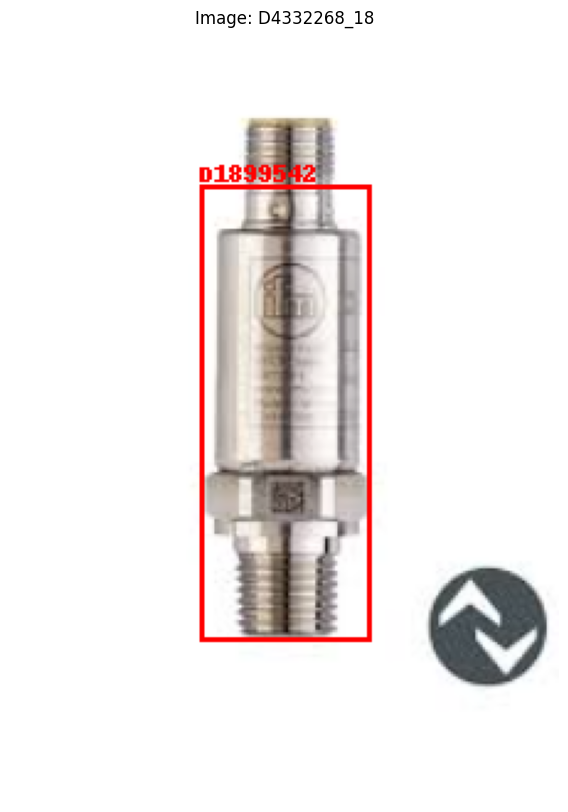

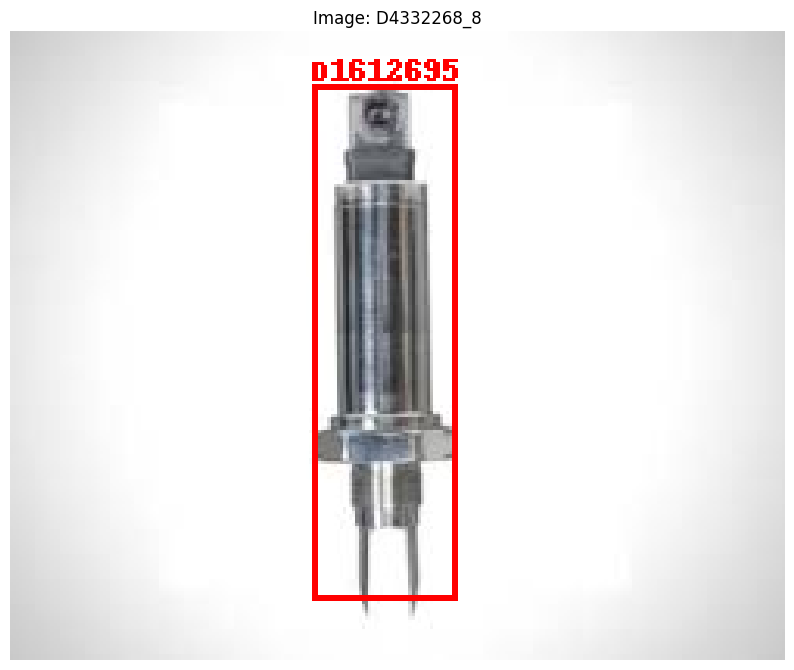

In [ ]:
# VISUALIZE:

import os
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import defaultdict

# Class mapping starting from 0
class_mapping = {
    'D1098590': 0,
    'D1100844': 1,
    'D1612695': 2,
    'D1899542': 3,
    'D4332268': 4,
}

# Reverse the class mapping for easier lookup by class index
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

def parse_yolo_annotation(txt_file, img_width, img_height):
  """Parse YOLO format annotation file to extract labels."""
    boxes = []
    labels = []

    with open(txt_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            label = int(data[0])
            x_center = float(data[1]) * img_width
            y_center = float(data[2]) * img_height
            width = float(data[3]) * img_width
            height = float(data[4]) * img_height
            xmin = int(x_center - width / 2)
            ymin = int(y_center - height / 2)
            xmax = int(x_center + width / 2)
            ymax = int(y_center + height / 2)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

    return boxes, labels

def visualize_images_with_annotations(img_dir, inferred_dir, num_images_per_class=3):
    img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
    class_to_files = defaultdict(list)

    # Group images by class based on filename
    for img_file in img_files:
        class_name_from_file = img_file[:8]
        if class_name_from_file in class_mapping:
            label = class_mapping[class_name_from_file]
            class_to_files[label].append(img_file)

    # Select random images for each class and sort by class order
    selected_files = []
    for label in sorted(class_to_files.keys()):
        files = class_to_files[label]
        selected_files.extend(random.sample(files, min(num_images_per_class, len(files))))

    # Load a font
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except IOError:
        font = ImageFont.load_default()

    # Visualize selected images with annotations
    for img_file in selected_files:
        base_name = img_file.replace('.png', '')
        inferred_file = base_name + '.txt'

        img_path = os.path.join(img_dir, img_file)
        inferred_path = os.path.join(inferred_dir, inferred_file)

        img = Image.open(img_path)
        img_width, img_height = img.size

        inferred_boxes, inferred_labels = parse_yolo_annotation(inferred_path, img_width, img_height)

        draw = ImageDraw.Draw(img)
        for box, label in zip(inferred_boxes, inferred_labels):
            xmin, ymin, xmax, ymax = box
            draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=2)
            class_name = reverse_class_mapping.get(label, "Unknown")
            text_position = (xmin, ymin - 10)
            draw.text(text_position, class_name, fill='red', font=font)  # Move class name above the box and make it bigger

        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(f"Image: {base_name}")
        plt.axis('off')
        plt.show()

# Perform visualization
img_dir = '/content/Datasets/actual_testing'
inferred_dir = '/content/Datasets/actual_testing_results'

visualize_images_with_annotations(img_dir, inferred_dir)